In [1]:
import sys
sys.path.append('..')

import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import gaussian, threshold_otsu
from skimage.transform import resize
from skimage import io
import pickle
from skimage.measure import regionprops

import matplotlib.pyplot as plt
import torch
import time
import model.model_cnnvae_conditional
import model.optimizer as optimizer
from sklearn.decomposition import PCA
import pandas as pd
import torchvision

In [2]:
prevSampled=0
nSamples=36
nProt=6
holdOutSamples_samples=[['HV1','P22','P14','P27'],['HV3','P46','P24','P37'],['HV5','P68','P44','P42'],['HV7','P15','P55','P59'],['HV8','P47','P63','P70'],['HV2','P57','P72','P83']]

In [3]:
sourceDir='/data/xinyi/c2p/data/chromark'
segDir=os.path.join(sourceDir,'nuclear_masks')
imgDir=os.path.join(sourceDir,'raw_data')
conditions=['controls','headneck','meningioma', 'glioma']

outSize=128
savename='pathCentered_'+str(outSize)


In [5]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [6]:
name_train='conditionClf_lord_p2p_fullrecon_sampling'
modelname_train='resnet18'
logsavepath_train=os.path.join('/data/xinyi/c2p/log/',modelname_train,name_train)
modelsavepath_train=os.path.join('/data/xinyi/c2p/models/',modelname_train,name_train)
plotsavepath_train=os.path.join('/data/xinyi/c2p/plots/',modelname_train,name_train)
if not os.path.exists(os.path.join('/data/xinyi/c2p/log/',modelname_train)):
    os.mkdir(os.path.join('/data/xinyi/c2p/log/',modelname_train))
    os.mkdir(os.path.join('/data/xinyi/c2p/models/',modelname_train))
    os.mkdir(os.path.join('/data/xinyi/c2p/plots/',modelname_train))
if not os.path.exists(logsavepath_train):
    os.mkdir(logsavepath_train)
if not os.path.exists(modelsavepath_train):
    os.mkdir(modelsavepath_train)
if not os.path.exists(plotsavepath_train):
    os.mkdir(plotsavepath_train)

In [7]:
def train(epoch,model_clf,optimizer_clf,inputImgs,inputImgs_val,labels_train,labels_val):
    np.random.seed(3)
    train_nodes_idx=np.arange(labels_train.size()[0])
    val_nodes_idx=np.arange(labels_val.size()[0])
    np.random.shuffle(train_nodes_idx)
    t = time.time()
    model_clf.train()
    loss_all=0
    
    ntrainBatches=int(np.ceil(train_nodes_idx.shape[0]/batchsize))
    for i in range(ntrainBatches):
#         if i%200==0:
#             print(i)
        trainIdx=train_nodes_idx[i*batchsize:min((i+1)*batchsize,train_nodes_idx.shape[0])]
        train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
        trainInput=torch.tensor(inputImgs[trainIdx]).cuda().float()

        optimizer_clf.zero_grad()

        pred = model_clf(trainInput)

        loss=loss_clf(pred, train_labels)
        loss_all+=loss.item()
            
        loss.backward()
        optimizer_clf.step()

    loss_all=loss_all/ntrainBatches
    
    with torch.no_grad():
        model_clf.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(val_nodes_idx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx=val_nodes_idx[i*batchsize:min((i+1)*batchsize,val_nodes_idx.shape[0])]
            val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
            valInput=torch.tensor(inputImgs_val[valIdx]).cuda().float()


            pred = model_clf(valInput)

            loss=loss_clf(pred, val_labels)
            loss_val_all+=loss.item()

        loss_val_all=loss_val_all/nvalBatches
    if epoch%10==0:
        print(' Epoch: {:04d}'.format(epoch),
              'loss_train: {:.4f}'.format(loss_all),
              'loss_val: {:.4f}'.format(loss_val_all),
              'time: {:.4f}s'.format(time.time() - t))
    return loss_all,loss_val_all


In [8]:
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname='',ctorder=None,vmin=None,vmax=None):
    if ctorder is None:
        ctorder=np.unique(ctlist)
    res=np.zeros((np.unique(labels).size,ctorder.size))
    for li in range(res.shape[0]):
        l=np.unique(labels)[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=ctorder[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=np.unique(labels)[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=ctorder[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=vmin,vmax=vmax)
    ax.set_yticks(np.arange(np.unique(labels).size))
    ax.set_yticklabels(np.unique(labels))
    ax.set_xticks(np.arange(ctorder.size))
    ax.set_xticklabels(ctorder)
    resplot=np.around(res,3)
    for i in range(resplot.shape[0]):
        for j in range(resplot.shape[1]):
            text = ax.text(j, i, resplot[i, j],
                           ha="center", va="center", color="r")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.colorbar(im)
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.pdf'))
    plt.close()
    return res

### load lord

In [9]:
sharedSizes=[1024]
dSpecific_filter=[(200,16)]
pID_type='randInit'
pIDemb_size=64

#VAE settings
seed=3
epochs=5001
saveFreq=100
lr=0.001 #initial learning rate
weight_decay=0 #Weight for L2 loss on embedding matrix.

# batchsize=4
batchsize=256
kernel_size=4
stride=2
padding=1

# fc_dim1=6000
hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=256
hidden5=96
hidden5_xy=4
fc_dim1=96*hidden5_xy*hidden5_xy
fc_dim2=6000

dropout=0.01
kl_weight=0.0000001


name_lord='splitChannels_conditional_lord_withNoise_bce'
modelname_lord='cnn_vae_pbmc_lord'
logsavepath_lord=os.path.join('/data/xinyi/c2p/log/',modelname_lord,name_lord)
modelsavepath_lord=os.path.join('/data/xinyi/c2p/models/',modelname_lord,name_lord)
plotsavepath_lord=os.path.join('/data/xinyi/c2p/plots/',modelname_lord,name_lord)

loadEpoch='3399'
loadEpoch_decoder=372

logsavepath_p_dna=os.path.join(logsavepath_lord,'dna')
modelsavepath_p_dna=os.path.join(modelsavepath_lord,'dna')
plotsavepath_p_dna=os.path.join(plotsavepath_lord,'dna')

logsavepath_p_protein=os.path.join(logsavepath_lord,'protein')
modelsavepath_p_protein=os.path.join(modelsavepath_lord,'protein')
plotsavepath_p_protein=os.path.join(plotsavepath_lord,'protein')

currLatentSize=sharedSizes[0]
dSpecificSize,dfilterSize=dSpecific_filter[0]

dna_cShared=hidden5-dfilterSize
p_cShared=dna_cShared

if modelname_lord=='cnn_vae_pbmc_lord':
    modelcnn_dna_dec = model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize+dSpecificSize,pIDemb_size)
    modelcnn_protein_dec = model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize+dSpecificSize,pIDemb_size)
    modelcnn_dnaShared_dec=model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize,pIDemb_size)
    modelcnn_pShared_dec=model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize,pIDemb_size)
modelcnn_dna_dec.cuda().eval()
modelcnn_protein_dec.cuda().eval()
modelcnn_dnaShared_dec.cuda().eval()
modelcnn_pShared_dec.cuda().eval()

batchsize=328
pIDemb_dec=torch.nn.Embedding(nProt, pIDemb_size).cuda()


with open(os.path.join(modelsavepath_p_protein,'pIDemb_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'rb') as output:
    pIDemb_dec.weight=pickle.load(output)

with open(os.path.join(modelsavepath_p_dna,'stateDict_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_dna_dec=pickle.load(output)
with open(os.path.join(modelsavepath_p_protein,'stateDict_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_protein_dec=pickle.load(output)
with open(os.path.join(modelsavepath_p_dna,'stateDictShared_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_dnaShared_dec=pickle.load(output)
with open(os.path.join(modelsavepath_p_protein,'stateDictShared_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_proteinShared_dec=pickle.load(output)

modelcnn_dna_dec.load_state_dict(stateDict_train_dna_dec[int(loadEpoch)])
modelcnn_dnaShared_dec.load_state_dict(stateDict_train_dnaShared_dec[int(loadEpoch)])
modelcnn_protein_dec.load_state_dict(stateDict_train_protein_dec[int(loadEpoch)])
modelcnn_pShared_dec.load_state_dict(stateDict_train_proteinShared_dec[int(loadEpoch)])
pIDemb_dec.weight.requires_grad=False

with open(os.path.join(modelsavepath_p_dna,'stateDict_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_dna=pickle.load( output)
with open(os.path.join(modelsavepath_p_protein,'stateDict_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_protein=pickle.load(output)

if modelname_lord=='cnn_vae_pbmc_lord':
    modelcnn_dna = model.model_cnnvae_conditional.CNN_VAE_split_encode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5,p_cShared,dna_cShared*hidden5_xy*hidden5_xy, (hidden5-p_cShared)*hidden5_xy*hidden5_xy,currLatentSize,dSpecificSize,nProt,'randInit',pIDemb_size)
    modelcnn_protein = model.model_cnnvae_conditional.CNN_VAE_split_encode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5,p_cShared,p_cShared*hidden5_xy*hidden5_xy, (hidden5-p_cShared)*hidden5_xy*hidden5_xy,currLatentSize,dSpecificSize,nProt,'randInit',pIDemb_size)
modelcnn_dna.cuda()
modelcnn_protein.cuda()
modelcnn_dna.load_state_dict(stateDict_train_dna[loadEpoch_decoder])
modelcnn_protein.load_state_dict(stateDict_train_protein[loadEpoch_decoder])





<All keys matched successfully>

In [10]:
modelcnn_dna.eval()
modelcnn_protein.eval()

CNN_VAE_split_encode_pIDemb(
  (pIDemb): Embedding(6, 64)
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=

### train classifier

In [11]:
seed=3
epochs=5001
saveFreq=50
lr=0.0001
weight_decay=0 #Weight for L2 loss on embedding matrix.

batchsize=256

18
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
18
cd16
4555


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1551 loss_val: 1.1807 time: 7.4304s
 Epoch: 0010 loss_train: 0.4199 loss_val: 1.6342 time: 6.6409s
 Epoch: 0020 loss_train: 0.1770 loss_val: 2.3280 time: 6.7024s
 Epoch: 0030 loss_train: 0.0496 loss_val: 2.5566 time: 7.1448s
 Epoch: 0040 loss_train: 0.0075 loss_val: 2.5977 time: 7.2745s
 Epoch: 0050 loss_train: 0.0039 loss_val: 2.5347 time: 7.4673s
 Epoch: 0060 loss_train: 0.0008 loss_val: 2.5930 time: 6.9520s
 Epoch: 0070 loss_train: 0.0004 loss_val: 2.6306 time: 6.0634s
 Epoch: 0080 loss_train: 0.0003 loss_val: 2.6694 time: 7.9967s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.7018 time: 6.4718s
 Epoch: 0100 loss_train: 0.0002 loss_val: 2.7307 time: 7.1439s
 Epoch: 0110 loss_train: 0.0002 loss_val: 2.7568 time: 6.0246s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.7816 time: 6.1255s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.8050 time: 6.8281s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.8272 time: 8.0306s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.8486 time: 

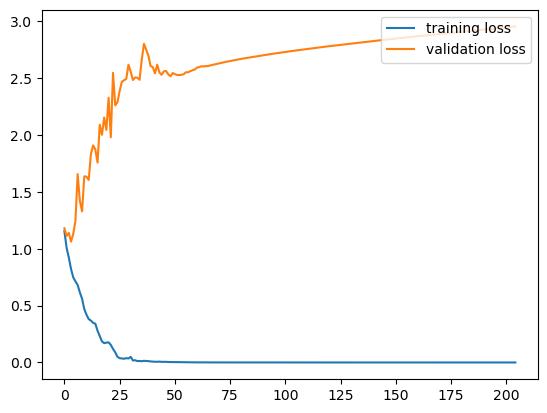

cd3
3760


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0296 loss_val: 1.0952 time: 4.8746s
 Epoch: 0010 loss_train: 0.0171 loss_val: 1.1936 time: 6.7784s
 Epoch: 0020 loss_train: 0.1148 loss_val: 1.8017 time: 7.0974s
 Epoch: 0030 loss_train: 0.0011 loss_val: 1.3526 time: 4.9785s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.4055 time: 6.5201s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4219 time: 7.2630s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4370 time: 5.1500s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.4509 time: 5.8068s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4640 time: 5.7247s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4762 time: 6.6228s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4880 time: 6.3684s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4992 time: 5.9934s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5101 time: 5.4337s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5207 time: 7.2391s
 Epoch: 0160 loss_train: 0.0001 loss_val: 1.5308 time: 5.8746s
 Epoch: 0170 loss_train: 0.0001 loss_val: 1.5409 time: 

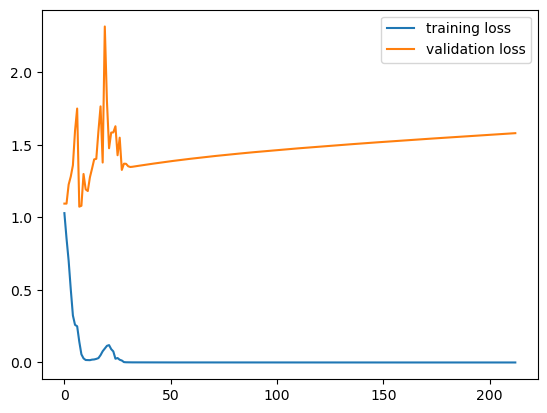

cd4
5580


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2011 loss_val: 1.4933 time: 8.7187s
 Epoch: 0010 loss_train: 0.3156 loss_val: 1.6252 time: 9.6517s
 Epoch: 0020 loss_train: 0.1734 loss_val: 2.2719 time: 8.1153s
 Epoch: 0030 loss_train: 0.0169 loss_val: 2.2779 time: 8.0100s
 Epoch: 0040 loss_train: 0.0135 loss_val: 2.4060 time: 7.4424s
 Epoch: 0050 loss_train: 0.0064 loss_val: 2.5089 time: 10.2841s
 Epoch: 0060 loss_train: 0.0010 loss_val: 2.5045 time: 7.6050s
 Epoch: 0070 loss_train: 0.0008 loss_val: 2.5385 time: 8.6101s
 Epoch: 0080 loss_train: 0.0007 loss_val: 2.5643 time: 8.1797s
 Epoch: 0090 loss_train: 0.0006 loss_val: 2.5832 time: 9.5720s
 Epoch: 0100 loss_train: 0.0013 loss_val: 2.5783 time: 8.9900s
 Epoch: 0110 loss_train: 0.0006 loss_val: 2.6191 time: 7.2820s
 Epoch: 0120 loss_train: 0.0006 loss_val: 2.6390 time: 6.9991s
 Epoch: 0130 loss_train: 0.0006 loss_val: 2.6531 time: 5.9271s
 Epoch: 0140 loss_train: 0.0005 loss_val: 2.6785 time: 8.5938s
 Epoch: 0150 loss_train: 0.0011 loss_val: 2.7521 time:

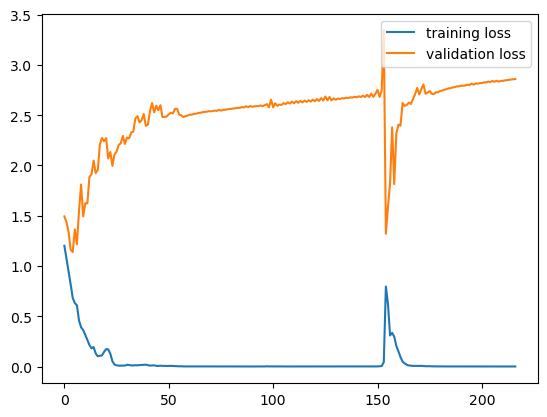

cd8
5604


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2129 loss_val: 1.6522 time: 9.1635s
 Epoch: 0010 loss_train: 0.1550 loss_val: 2.0449 time: 8.9104s
 Epoch: 0020 loss_train: 0.0322 loss_val: 2.0201 time: 8.9674s
 Epoch: 0030 loss_train: 0.0013 loss_val: 2.0725 time: 7.6202s
 Epoch: 0040 loss_train: 0.0006 loss_val: 2.1223 time: 8.4030s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.1670 time: 9.8025s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.2046 time: 8.3021s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.2375 time: 8.6696s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.2674 time: 7.5456s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.2949 time: 8.4198s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.3208 time: 7.9096s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.3453 time: 9.3124s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.3689 time: 8.6559s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.3916 time: 7.6208s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.4135 time: 9.0618s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.4349 time: 

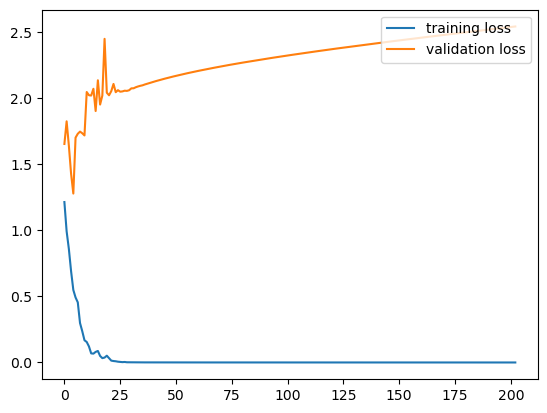

gh2ax
4837


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0205 loss_val: 1.7969 time: 7.6214s
 Epoch: 0010 loss_train: 0.0098 loss_val: 1.0112 time: 6.6621s
 Epoch: 0020 loss_train: 0.0008 loss_val: 1.0355 time: 7.3011s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.0719 time: 7.0974s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.1005 time: 7.6603s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.1243 time: 5.4203s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.1448 time: 6.4670s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.1632 time: 7.1546s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.1796 time: 6.0152s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.1949 time: 7.0000s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.2091 time: 7.7329s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.2225 time: 7.0731s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.2352 time: 5.0231s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.2473 time: 6.4538s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.2590 time: 8.1084s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.2702 time: 

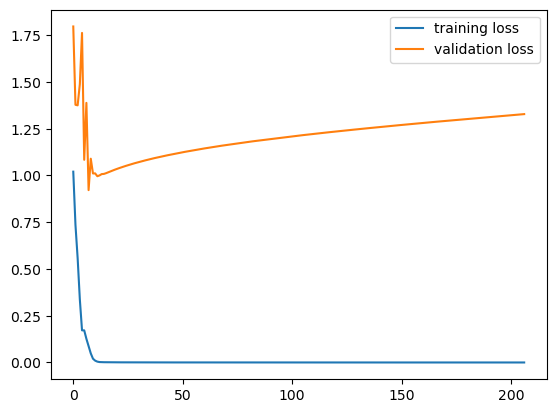

lamin
4838


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1265 loss_val: 1.4892 time: 7.2073s
 Epoch: 0010 loss_train: 0.1003 loss_val: 1.0534 time: 8.1514s
 Epoch: 0020 loss_train: 0.0125 loss_val: 1.1526 time: 7.5885s
 Epoch: 0030 loss_train: 0.0158 loss_val: 1.3416 time: 7.3736s
 Epoch: 0040 loss_train: 0.0518 loss_val: 1.5010 time: 7.2862s
 Epoch: 0050 loss_train: 0.0153 loss_val: 1.5643 time: 7.1899s
 Epoch: 0060 loss_train: 0.0004 loss_val: 1.3918 time: 7.5410s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4065 time: 6.7722s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4188 time: 7.6721s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4296 time: 6.6697s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4394 time: 7.7069s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4488 time: 7.7222s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4578 time: 6.6387s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4664 time: 7.1395s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4749 time: 9.1102s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.4832 time: 

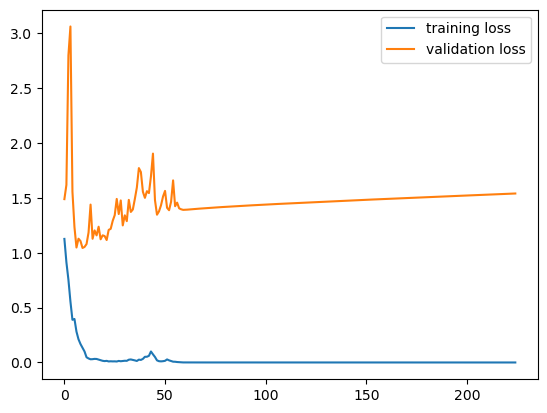

19
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
19
cd16
4490


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1425 loss_val: 1.2404 time: 8.0771s
 Epoch: 0010 loss_train: 0.4275 loss_val: 1.9011 time: 6.1673s
 Epoch: 0020 loss_train: 0.0715 loss_val: 2.5599 time: 7.9952s
 Epoch: 0030 loss_train: 0.0397 loss_val: 2.7292 time: 7.8038s
 Epoch: 0040 loss_train: 0.0337 loss_val: 2.9837 time: 5.5236s
 Epoch: 0050 loss_train: 0.0166 loss_val: 2.6629 time: 7.1558s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.6073 time: 6.8913s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.6209 time: 8.8880s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.6351 time: 6.5024s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.6489 time: 6.7722s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.6621 time: 6.9137s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.6751 time: 7.7061s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.6879 time: 7.4790s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.7002 time: 6.4268s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.7124 time: 6.8335s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.7245 time: 

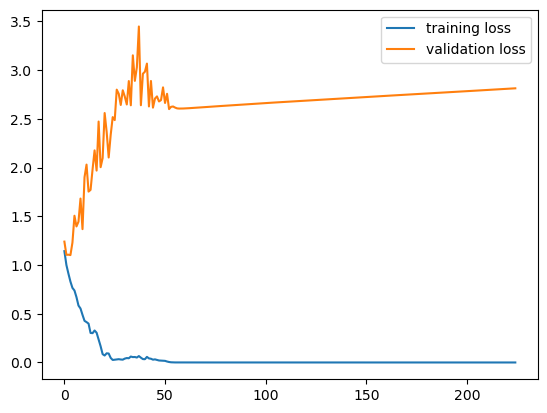

cd3
3802


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0088 loss_val: 1.1009 time: 6.0404s
 Epoch: 0010 loss_train: 0.0736 loss_val: 1.1072 time: 5.8854s
 Epoch: 0020 loss_train: 0.0013 loss_val: 1.1265 time: 5.0831s
 Epoch: 0030 loss_train: 0.0007 loss_val: 1.1640 time: 4.7757s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.1930 time: 7.0041s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.2169 time: 6.4340s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.2373 time: 5.4115s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.2554 time: 5.6429s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.2717 time: 5.7247s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.2866 time: 5.5945s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3006 time: 3.9998s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3137 time: 5.0185s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3259 time: 5.1147s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3377 time: 5.2723s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.3488 time: 6.9768s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.3596 time: 

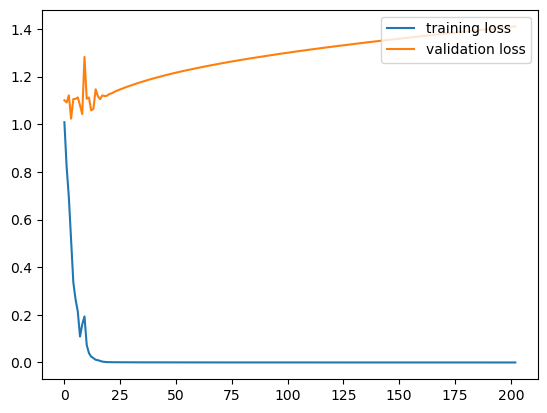

cd4
5518


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1779 loss_val: 1.4196 time: 7.9999s
 Epoch: 0010 loss_train: 0.3410 loss_val: 1.5426 time: 9.9687s
 Epoch: 0020 loss_train: 0.0464 loss_val: 2.0983 time: 7.6274s
 Epoch: 0030 loss_train: 0.0053 loss_val: 2.4681 time: 9.0601s
 Epoch: 0040 loss_train: 0.0005 loss_val: 2.3391 time: 7.7526s
 Epoch: 0050 loss_train: 0.0003 loss_val: 2.3726 time: 9.3099s
 Epoch: 0060 loss_train: 0.0002 loss_val: 2.4040 time: 7.2371s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.4331 time: 6.8364s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.4603 time: 7.7273s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.4862 time: 8.3862s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.5106 time: 9.2575s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.5338 time: 8.7211s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.5561 time: 8.0488s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.5778 time: 9.3548s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.5988 time: 8.5554s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.6195 time: 

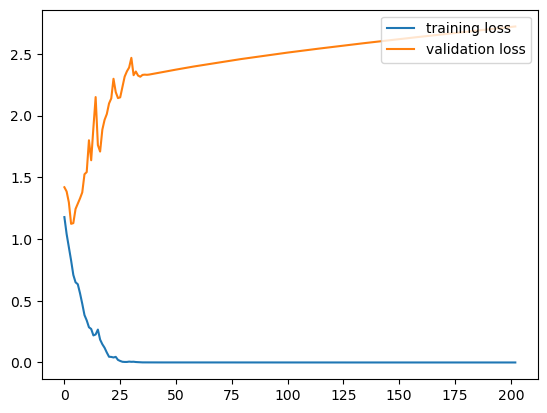

cd8
5545


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1879 loss_val: 1.5962 time: 7.2079s
 Epoch: 0010 loss_train: 0.1003 loss_val: 1.8431 time: 9.1695s
 Epoch: 0020 loss_train: 0.0164 loss_val: 2.1039 time: 8.4258s
 Epoch: 0030 loss_train: 0.0011 loss_val: 2.1476 time: 7.9605s
 Epoch: 0040 loss_train: 0.0005 loss_val: 2.1626 time: 6.8272s
 Epoch: 0050 loss_train: 0.0003 loss_val: 2.1951 time: 7.4124s
 Epoch: 0060 loss_train: 0.0002 loss_val: 2.2236 time: 5.7655s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.2495 time: 7.5579s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.2737 time: 8.0503s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.2961 time: 8.3422s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.3173 time: 7.1565s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.3377 time: 9.2571s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.3574 time: 9.3084s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.3765 time: 8.9306s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.3952 time: 8.4331s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.4136 time: 

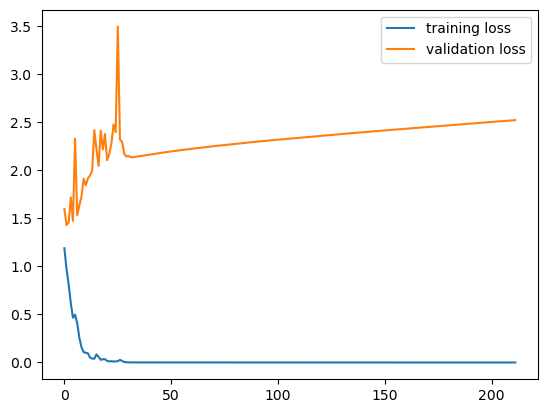

gh2ax
4931


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9949 loss_val: 2.0281 time: 5.8161s
 Epoch: 0010 loss_train: 0.0152 loss_val: 1.1213 time: 8.1309s
 Epoch: 0020 loss_train: 0.0009 loss_val: 1.1178 time: 6.4970s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.1584 time: 8.0228s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.1889 time: 7.7646s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.2139 time: 8.8337s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.2355 time: 7.3623s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.2550 time: 7.1203s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.2726 time: 7.0629s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.2889 time: 7.2469s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3041 time: 7.7437s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3184 time: 6.4768s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3321 time: 7.4851s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3453 time: 7.7641s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.3579 time: 6.0617s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.3701 time: 

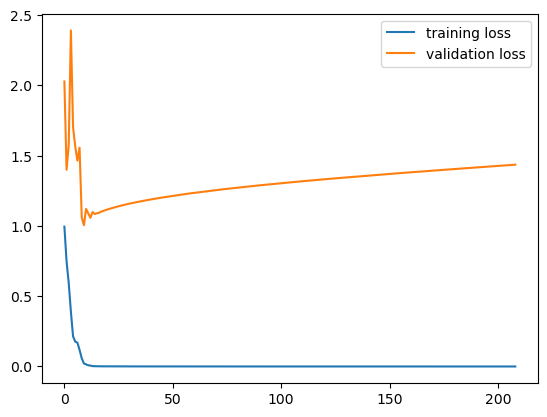

lamin
4932


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1819 loss_val: 1.4626 time: 4.6216s
 Epoch: 0010 loss_train: 0.0924 loss_val: 1.3362 time: 7.4599s
 Epoch: 0020 loss_train: 0.0363 loss_val: 1.4301 time: 7.2496s
 Epoch: 0030 loss_train: 0.0212 loss_val: 1.8290 time: 6.1334s
 Epoch: 0040 loss_train: 0.0342 loss_val: 1.6149 time: 8.5318s
 Epoch: 0050 loss_train: 0.0265 loss_val: 1.9420 time: 6.5967s
 Epoch: 0060 loss_train: 0.0032 loss_val: 1.6777 time: 7.1966s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5992 time: 7.4388s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.6013 time: 7.8057s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.6082 time: 7.6859s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6152 time: 7.4539s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6223 time: 7.7268s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6293 time: 7.9013s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6363 time: 8.2098s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.6433 time: 5.9949s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.6502 time: 

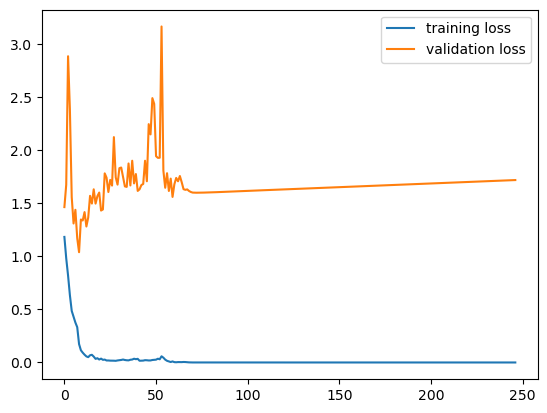

20
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
20
cd16
4629


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1492 loss_val: 1.1855 time: 6.9375s
 Epoch: 0010 loss_train: 0.4937 loss_val: 1.6639 time: 6.6364s
 Epoch: 0020 loss_train: 0.1633 loss_val: 2.7428 time: 7.0645s
 Epoch: 0030 loss_train: 0.0350 loss_val: 2.6146 time: 7.9869s
 Epoch: 0040 loss_train: 0.0188 loss_val: 2.7249 time: 5.8151s
 Epoch: 0050 loss_train: 0.0031 loss_val: 2.6211 time: 5.8554s
 Epoch: 0060 loss_train: 0.0041 loss_val: 2.7040 time: 8.4233s
 Epoch: 0070 loss_train: 0.0027 loss_val: 2.7443 time: 7.9377s
 Epoch: 0080 loss_train: 0.0016 loss_val: 2.7673 time: 6.5353s
 Epoch: 0090 loss_train: 0.0030 loss_val: 2.8169 time: 7.4130s
 Epoch: 0100 loss_train: 0.0030 loss_val: 2.8244 time: 7.3013s
 Epoch: 0110 loss_train: 0.0007 loss_val: 2.8569 time: 7.7638s
 Epoch: 0120 loss_train: 0.0060 loss_val: 2.8762 time: 7.7313s
 Epoch: 0130 loss_train: 0.7537 loss_val: 1.3297 time: 6.9896s
 Epoch: 0140 loss_train: 0.0445 loss_val: 2.7360 time: 6.2070s
 Epoch: 0150 loss_train: 0.0047 loss_val: 2.8531 time: 

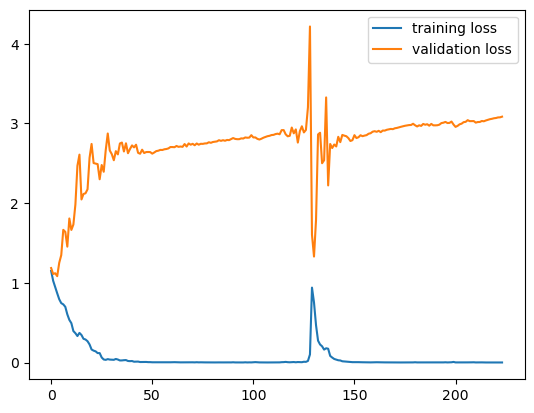

cd3
3806


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0314 loss_val: 1.0919 time: 7.3746s
 Epoch: 0010 loss_train: 0.0501 loss_val: 1.2541 time: 5.7227s
 Epoch: 0020 loss_train: 0.0146 loss_val: 1.7734 time: 5.6712s
 Epoch: 0030 loss_train: 0.0832 loss_val: 2.0238 time: 6.2967s
 Epoch: 0040 loss_train: 0.0059 loss_val: 1.5101 time: 5.2064s
 Epoch: 0050 loss_train: 0.0005 loss_val: 1.4821 time: 6.7213s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.4985 time: 6.8150s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5131 time: 6.4602s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.5264 time: 5.0883s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.5388 time: 6.8995s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5505 time: 5.4904s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5617 time: 5.6718s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5723 time: 5.2001s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5826 time: 5.5667s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5926 time: 5.9002s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6024 time: 

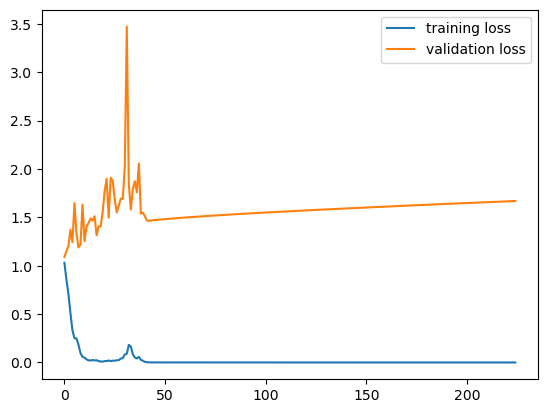

cd4
5663


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2202 loss_val: 1.5565 time: 6.5194s
 Epoch: 0010 loss_train: 0.4115 loss_val: 1.6477 time: 8.4723s
 Epoch: 0020 loss_train: 0.1419 loss_val: 2.2772 time: 9.8845s
 Epoch: 0030 loss_train: 0.0089 loss_val: 2.2253 time: 7.3143s
 Epoch: 0040 loss_train: 0.0067 loss_val: 2.4144 time: 7.4916s
 Epoch: 0050 loss_train: 0.0067 loss_val: 2.3603 time: 7.3491s
 Epoch: 0060 loss_train: 0.0006 loss_val: 2.4244 time: 9.1537s
 Epoch: 0070 loss_train: 0.0005 loss_val: 2.4580 time: 8.2265s
 Epoch: 0080 loss_train: 0.0005 loss_val: 2.4840 time: 8.3592s
 Epoch: 0090 loss_train: 0.0004 loss_val: 2.5104 time: 7.6409s
 Epoch: 0100 loss_train: 0.0005 loss_val: 2.5296 time: 6.5250s
 Epoch: 0110 loss_train: 0.0003 loss_val: 2.5526 time: 7.0194s
 Epoch: 0120 loss_train: 0.0004 loss_val: 2.5699 time: 7.6359s
 Epoch: 0130 loss_train: 0.0003 loss_val: 2.5902 time: 7.8055s
 Epoch: 0140 loss_train: 0.0004 loss_val: 2.6069 time: 7.2046s
 Epoch: 0150 loss_train: 0.0003 loss_val: 2.6248 time: 

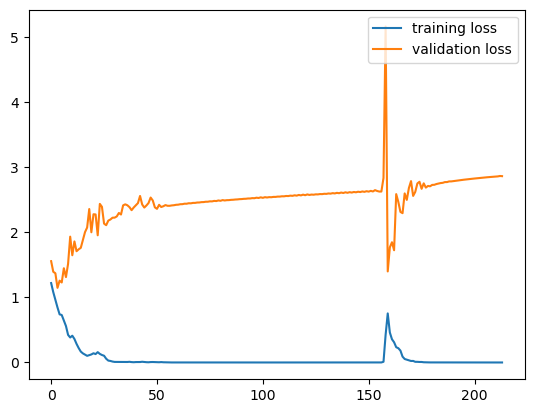

cd8
5687


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2263 loss_val: 1.6314 time: 7.2061s
 Epoch: 0010 loss_train: 0.1523 loss_val: 1.8247 time: 8.8429s
 Epoch: 0020 loss_train: 0.0109 loss_val: 2.1204 time: 7.1581s
 Epoch: 0030 loss_train: 0.0017 loss_val: 2.0816 time: 6.9262s
 Epoch: 0040 loss_train: 0.0006 loss_val: 2.1292 time: 7.2904s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.1810 time: 6.4110s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.2216 time: 7.3715s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.2568 time: 7.4078s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.2883 time: 8.6453s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.3176 time: 7.3469s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.3449 time: 7.4793s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.3706 time: 7.2978s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.3952 time: 7.9914s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.4189 time: 8.7485s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.4418 time: 6.9698s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.4641 time: 

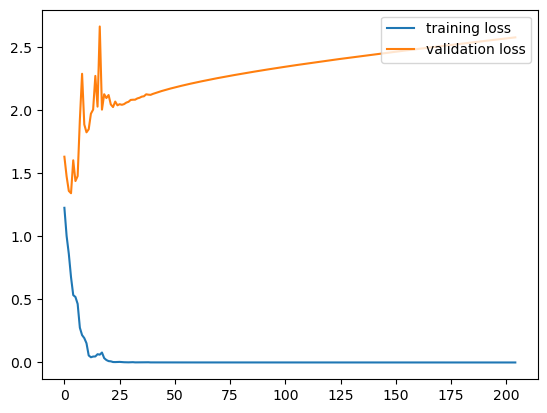

gh2ax
4889


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0546 loss_val: 1.6057 time: 5.9470s
 Epoch: 0010 loss_train: 0.0098 loss_val: 1.0836 time: 5.5292s
 Epoch: 0020 loss_train: 0.0009 loss_val: 1.1727 time: 7.1675s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.2154 time: 7.7642s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.2482 time: 5.3029s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.2755 time: 7.7898s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.2994 time: 7.6390s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3204 time: 8.5939s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3394 time: 6.1052s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3570 time: 7.2319s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3735 time: 8.4044s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3890 time: 9.0831s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4038 time: 7.3889s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4179 time: 7.3860s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.4316 time: 6.8784s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4447 time: 

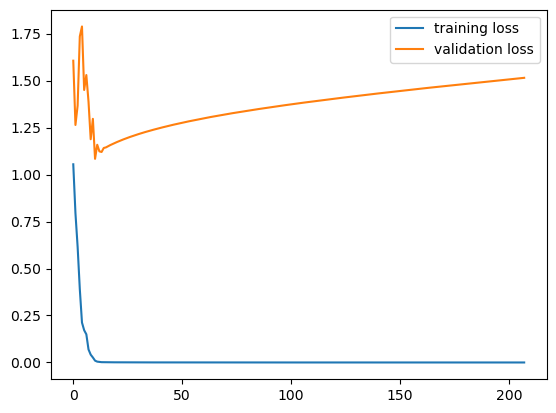

lamin
4890


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2057 loss_val: 1.3907 time: 6.6475s
 Epoch: 0010 loss_train: 0.1183 loss_val: 1.8844 time: 5.6007s
 Epoch: 0020 loss_train: 0.0069 loss_val: 1.3135 time: 6.1855s
 Epoch: 0030 loss_train: 0.0047 loss_val: 1.4125 time: 6.7284s
 Epoch: 0040 loss_train: 0.1846 loss_val: 1.9549 time: 7.5292s
 Epoch: 0050 loss_train: 0.0011 loss_val: 1.4868 time: 7.7035s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.5039 time: 7.2482s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5202 time: 7.8800s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.5345 time: 5.4464s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.5474 time: 5.1002s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5596 time: 7.3083s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5711 time: 5.6178s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5822 time: 7.3064s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5927 time: 5.3861s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6030 time: 7.1920s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6131 time: 

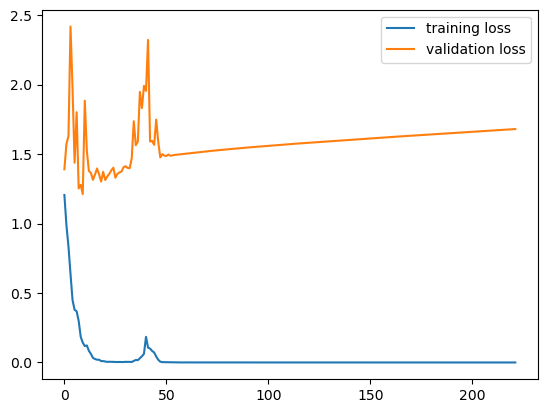

21
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
21
cd16
4560


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1544 loss_val: 1.2258 time: 7.4159s
 Epoch: 0010 loss_train: 0.4377 loss_val: 1.7189 time: 7.0938s
 Epoch: 0020 loss_train: 0.1880 loss_val: 1.8818 time: 8.1402s
 Epoch: 0030 loss_train: 0.0128 loss_val: 2.2845 time: 7.6099s
 Epoch: 0040 loss_train: 0.0270 loss_val: 2.6278 time: 7.5031s
 Epoch: 0050 loss_train: 0.1253 loss_val: 2.9855 time: 6.1796s
 Epoch: 0060 loss_train: 0.0057 loss_val: 2.4113 time: 8.7207s
 Epoch: 0070 loss_train: 0.0008 loss_val: 2.4409 time: 6.4495s
 Epoch: 0080 loss_train: 0.0008 loss_val: 2.4845 time: 7.9160s
 Epoch: 0090 loss_train: 0.0006 loss_val: 2.5146 time: 7.9344s
 Epoch: 0100 loss_train: 0.0006 loss_val: 2.5381 time: 6.3730s
 Epoch: 0110 loss_train: 0.0005 loss_val: 2.5643 time: 8.1484s
 Epoch: 0120 loss_train: 0.0005 loss_val: 2.5829 time: 8.6777s
 Epoch: 0130 loss_train: 0.0005 loss_val: 2.6052 time: 6.5736s
 Epoch: 0140 loss_train: 0.0004 loss_val: 2.6150 time: 7.8062s
 Epoch: 0150 loss_train: 0.0004 loss_val: 2.6386 time: 

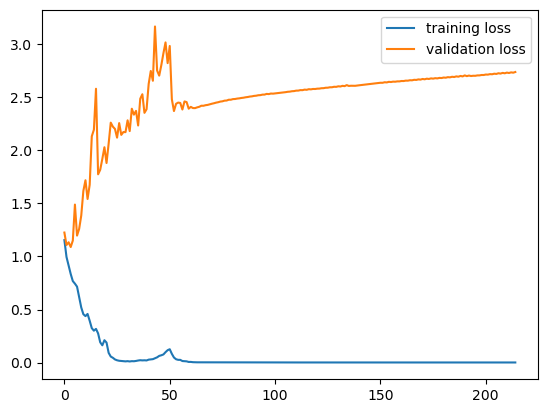

cd3
3772


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0149 loss_val: 1.1052 time: 6.1444s
 Epoch: 0010 loss_train: 0.0317 loss_val: 1.4292 time: 6.0668s
 Epoch: 0020 loss_train: 0.0382 loss_val: 1.9383 time: 6.1961s
 Epoch: 0030 loss_train: 0.0512 loss_val: 2.6240 time: 6.3733s
 Epoch: 0040 loss_train: 0.0031 loss_val: 1.6010 time: 5.6591s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.5375 time: 5.4420s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.5485 time: 3.9230s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5593 time: 5.3450s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.5694 time: 4.6369s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5790 time: 6.5647s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5881 time: 6.9908s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5970 time: 5.4450s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6055 time: 6.9820s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6138 time: 6.1538s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6219 time: 6.0216s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6299 time: 

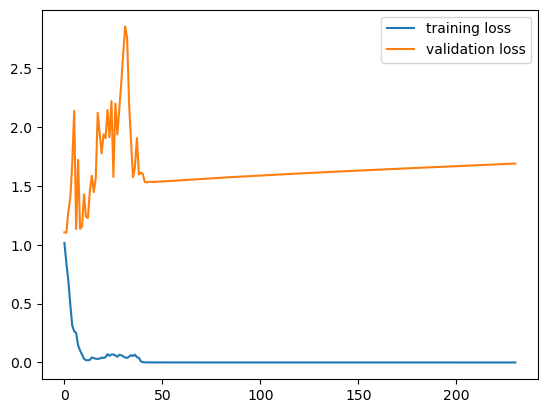

cd4
5602


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2045 loss_val: 1.5280 time: 8.6019s
 Epoch: 0010 loss_train: 0.2845 loss_val: 1.5025 time: 7.2322s
 Epoch: 0020 loss_train: 0.0746 loss_val: 1.9768 time: 7.8406s
 Epoch: 0030 loss_train: 0.0107 loss_val: 2.1709 time: 8.2267s
 Epoch: 0040 loss_train: 0.0111 loss_val: 2.3352 time: 8.3644s
 Epoch: 0050 loss_train: 0.0014 loss_val: 2.2926 time: 8.5089s
 Epoch: 0060 loss_train: 0.0008 loss_val: 2.3170 time: 9.0139s
 Epoch: 0070 loss_train: 0.0008 loss_val: 2.3416 time: 8.3517s
 Epoch: 0080 loss_train: 0.0007 loss_val: 2.3675 time: 8.3079s
 Epoch: 0090 loss_train: 0.0008 loss_val: 2.3921 time: 9.2826s
 Epoch: 0100 loss_train: 0.0006 loss_val: 2.4098 time: 9.2188s
 Epoch: 0110 loss_train: 0.0006 loss_val: 2.4287 time: 7.6886s
 Epoch: 0120 loss_train: 0.0007 loss_val: 2.4479 time: 8.8261s
 Epoch: 0130 loss_train: 0.0006 loss_val: 2.4656 time: 9.0807s
 Epoch: 0140 loss_train: 0.0006 loss_val: 2.4903 time: 7.9572s
 Epoch: 0150 loss_train: 0.0006 loss_val: 2.5026 time: 

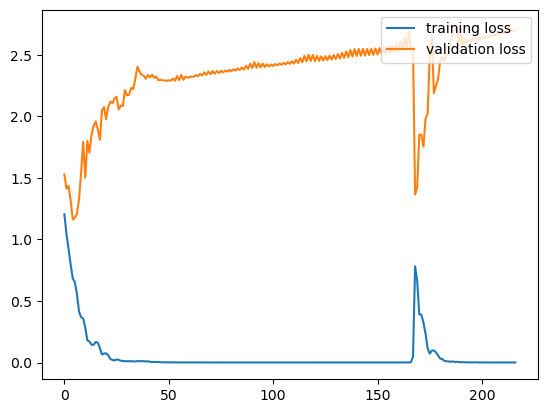

cd8
5625


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2101 loss_val: 1.7196 time: 10.3763s
 Epoch: 0010 loss_train: 0.1117 loss_val: 1.7751 time: 10.3085s
 Epoch: 0020 loss_train: 0.0147 loss_val: 1.8711 time: 9.7742s
 Epoch: 0030 loss_train: 0.0026 loss_val: 1.9134 time: 7.5902s
 Epoch: 0040 loss_train: 0.0014 loss_val: 1.9740 time: 9.1373s
 Epoch: 0050 loss_train: 0.0013 loss_val: 2.0183 time: 7.8599s
 Epoch: 0060 loss_train: 0.0010 loss_val: 2.0495 time: 7.2831s
 Epoch: 0070 loss_train: 0.0009 loss_val: 2.0768 time: 8.8922s
 Epoch: 0080 loss_train: 0.0010 loss_val: 2.1096 time: 7.2398s
 Epoch: 0090 loss_train: 0.0007 loss_val: 2.1230 time: 8.6759s
 Epoch: 0100 loss_train: 0.0012 loss_val: 2.1623 time: 9.5291s
 Epoch: 0110 loss_train: 0.1222 loss_val: 2.1900 time: 7.4909s
 Epoch: 0120 loss_train: 0.0027 loss_val: 2.1988 time: 9.4051s
 Epoch: 0130 loss_train: 0.0013 loss_val: 2.2573 time: 8.6919s
 Epoch: 0140 loss_train: 0.0008 loss_val: 2.3108 time: 9.8486s
 Epoch: 0150 loss_train: 0.0007 loss_val: 2.3465 time

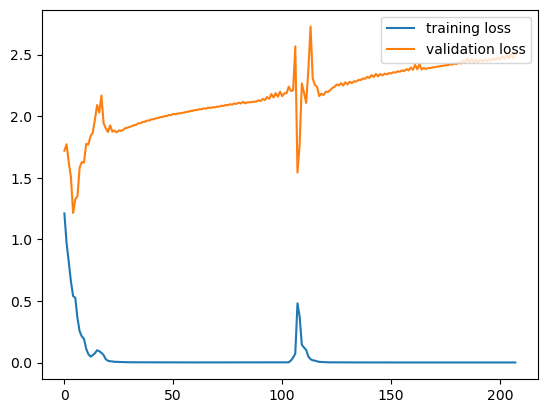

gh2ax
4892


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0451 loss_val: 1.6116 time: 7.7197s
 Epoch: 0010 loss_train: 0.0395 loss_val: 1.2461 time: 5.8933s
 Epoch: 0020 loss_train: 0.0008 loss_val: 1.2275 time: 5.2016s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.2632 time: 7.2735s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.2915 time: 7.0851s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.3155 time: 7.4087s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3366 time: 5.4796s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.3556 time: 6.1537s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3730 time: 7.7960s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3893 time: 5.9011s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4046 time: 5.4483s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4192 time: 6.0568s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4333 time: 7.6169s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4467 time: 7.4849s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.4598 time: 6.4606s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4724 time: 

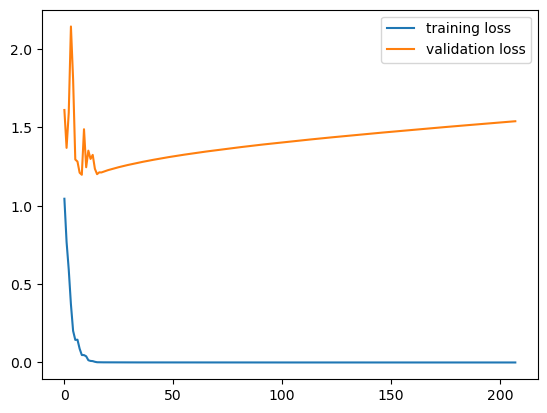

lamin
4893


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1876 loss_val: 1.3697 time: 7.9668s
 Epoch: 0010 loss_train: 0.1796 loss_val: 1.3275 time: 7.7177s
 Epoch: 0020 loss_train: 0.0149 loss_val: 1.3179 time: 7.5530s
 Epoch: 0030 loss_train: 0.0130 loss_val: 1.5835 time: 8.2548s
 Epoch: 0040 loss_train: 0.0007 loss_val: 1.4495 time: 7.1030s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.4617 time: 8.7388s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.4755 time: 6.4095s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4879 time: 8.7275s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4996 time: 7.9674s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5107 time: 7.7314s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5215 time: 8.0074s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5320 time: 5.6817s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5423 time: 7.6975s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5525 time: 6.9900s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5622 time: 8.5191s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5723 time: 

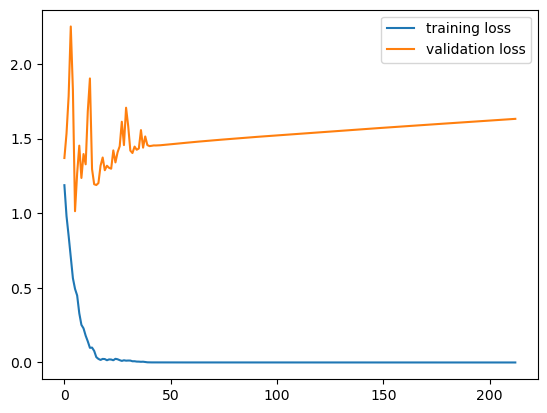

22
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
22
cd16
4544


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1240 loss_val: 1.2110 time: 7.7708s
 Epoch: 0010 loss_train: 0.5156 loss_val: 1.5119 time: 6.0211s
 Epoch: 0020 loss_train: 0.1100 loss_val: 2.8012 time: 7.9440s
 Epoch: 0030 loss_train: 0.0635 loss_val: 2.6383 time: 5.9808s
 Epoch: 0040 loss_train: 0.0603 loss_val: 3.1648 time: 6.0134s
 Epoch: 0050 loss_train: 0.0206 loss_val: 2.8331 time: 6.6717s
 Epoch: 0060 loss_train: 0.0018 loss_val: 2.6539 time: 6.5755s
 Epoch: 0070 loss_train: 0.0015 loss_val: 2.6922 time: 7.3700s
 Epoch: 0080 loss_train: 0.0021 loss_val: 2.7164 time: 7.8489s
 Epoch: 0090 loss_train: 0.0011 loss_val: 2.7303 time: 8.1539s
 Epoch: 0100 loss_train: 0.0009 loss_val: 2.7528 time: 5.9746s
 Epoch: 0110 loss_train: 0.0010 loss_val: 2.7749 time: 7.1435s
 Epoch: 0120 loss_train: 0.0008 loss_val: 2.7861 time: 8.0579s
 Epoch: 0130 loss_train: 0.0008 loss_val: 2.8057 time: 7.5506s
 Epoch: 0140 loss_train: 0.0008 loss_val: 2.8184 time: 8.5147s
 Epoch: 0150 loss_train: 0.0008 loss_val: 2.8331 time: 

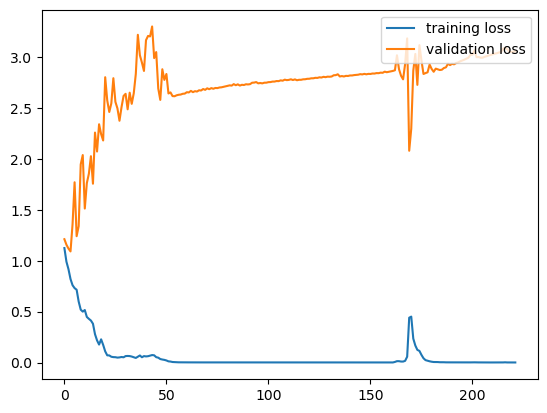

cd3
3781


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0299 loss_val: 1.0953 time: 5.8318s
 Epoch: 0010 loss_train: 0.0224 loss_val: 1.1448 time: 5.1553s
 Epoch: 0020 loss_train: 0.0014 loss_val: 1.2215 time: 5.1764s
 Epoch: 0030 loss_train: 0.0008 loss_val: 1.2698 time: 3.9780s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.3050 time: 6.8362s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.3338 time: 5.3785s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.3583 time: 5.5099s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3798 time: 6.6031s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.3992 time: 5.8552s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.4168 time: 5.6126s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4330 time: 5.7390s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4481 time: 6.1516s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4624 time: 4.8166s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4760 time: 5.3836s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4888 time: 5.9028s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5011 time: 

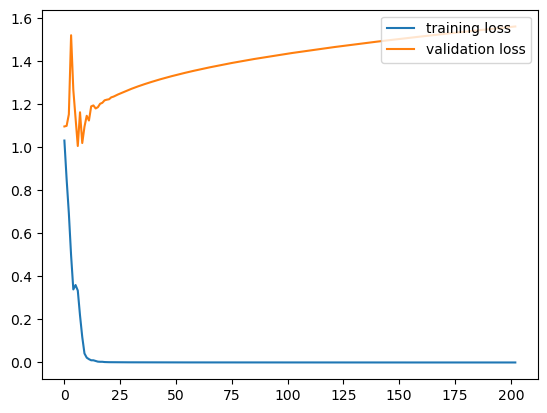

cd4
5579


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2136 loss_val: 1.5765 time: 6.4306s
 Epoch: 0010 loss_train: 0.3354 loss_val: 1.6346 time: 8.5271s
 Epoch: 0020 loss_train: 0.0614 loss_val: 2.2449 time: 7.6581s
 Epoch: 0030 loss_train: 0.0186 loss_val: 2.4010 time: 6.9404s
 Epoch: 0040 loss_train: 0.0109 loss_val: 2.5590 time: 7.9248s
 Epoch: 0050 loss_train: 0.0092 loss_val: 2.5969 time: 7.6226s
 Epoch: 0060 loss_train: 0.0107 loss_val: 2.8525 time: 6.5951s
 Epoch: 0070 loss_train: 0.0010 loss_val: 2.5625 time: 7.9945s
 Epoch: 0080 loss_train: 0.0007 loss_val: 2.5887 time: 7.5916s
 Epoch: 0090 loss_train: 0.0006 loss_val: 2.6050 time: 7.3917s
 Epoch: 0100 loss_train: 0.0006 loss_val: 2.6286 time: 8.9086s
 Epoch: 0110 loss_train: 0.0006 loss_val: 2.6370 time: 7.1733s
 Epoch: 0120 loss_train: 0.0006 loss_val: 2.6607 time: 7.4213s
 Epoch: 0130 loss_train: 0.0006 loss_val: 2.6670 time: 8.5098s
 Epoch: 0140 loss_train: 0.0006 loss_val: 2.6918 time: 7.1658s
 Epoch: 0150 loss_train: 0.0006 loss_val: 2.6951 time: 

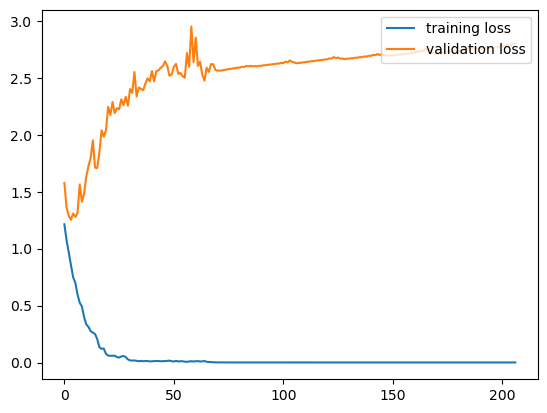

cd8
5605


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2169 loss_val: 1.6090 time: 9.2544s
 Epoch: 0010 loss_train: 0.1702 loss_val: 1.5990 time: 9.8667s
 Epoch: 0020 loss_train: 0.0142 loss_val: 2.0293 time: 7.2325s
 Epoch: 0030 loss_train: 0.0079 loss_val: 2.2180 time: 8.5578s
 Epoch: 0040 loss_train: 0.0015 loss_val: 2.1335 time: 8.5845s
 Epoch: 0050 loss_train: 0.0007 loss_val: 2.1646 time: 8.3483s
 Epoch: 0060 loss_train: 0.0006 loss_val: 2.1943 time: 7.7976s
 Epoch: 0070 loss_train: 0.0006 loss_val: 2.2207 time: 7.3663s
 Epoch: 0080 loss_train: 0.0005 loss_val: 2.2471 time: 7.1644s
 Epoch: 0090 loss_train: 0.0004 loss_val: 2.2704 time: 8.2657s
 Epoch: 0100 loss_train: 0.0004 loss_val: 2.2868 time: 6.9695s
 Epoch: 0110 loss_train: 0.0004 loss_val: 2.3119 time: 6.9500s
 Epoch: 0120 loss_train: 0.0004 loss_val: 2.3355 time: 6.3299s
 Epoch: 0130 loss_train: 0.0004 loss_val: 2.3611 time: 5.8090s
 Epoch: 0140 loss_train: 0.0004 loss_val: 2.3788 time: 7.1275s
 Epoch: 0150 loss_train: 0.0004 loss_val: 2.4061 time: 

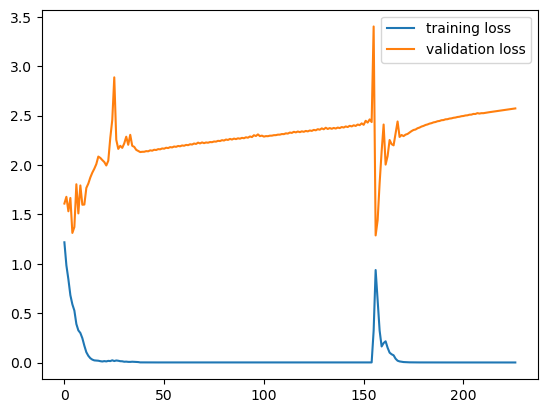

gh2ax
4926


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0335 loss_val: 1.5519 time: 6.8703s
 Epoch: 0010 loss_train: 0.0092 loss_val: 1.2605 time: 7.8031s
 Epoch: 0020 loss_train: 0.0009 loss_val: 1.2592 time: 6.6306s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.3011 time: 8.1476s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.3338 time: 8.3625s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.3611 time: 8.6299s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3846 time: 8.5590s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4054 time: 7.3941s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.4245 time: 8.2586s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4420 time: 7.1714s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4585 time: 6.1553s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4742 time: 8.6241s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4889 time: 7.4118s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5032 time: 7.5355s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.5170 time: 8.1611s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.5303 time: 

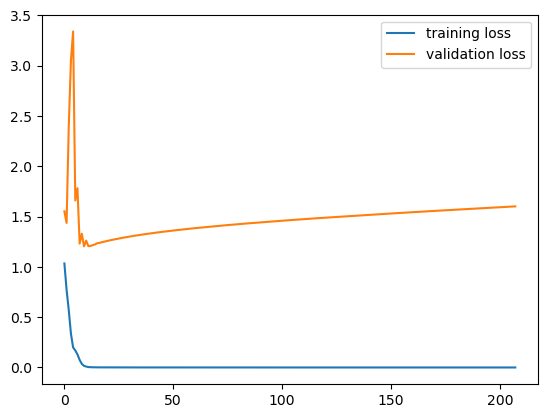

lamin
4927


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1934 loss_val: 1.4729 time: 8.1645s
 Epoch: 0010 loss_train: 0.2250 loss_val: 1.3011 time: 6.2494s
 Epoch: 0020 loss_train: 0.0095 loss_val: 1.3719 time: 7.3922s
 Epoch: 0030 loss_train: 0.0114 loss_val: 1.4585 time: 6.7931s
 Epoch: 0040 loss_train: 0.0059 loss_val: 1.6370 time: 7.2591s
 Epoch: 0050 loss_train: 0.0599 loss_val: 1.6212 time: 6.9952s
 Epoch: 0060 loss_train: 0.0005 loss_val: 1.5123 time: 7.6716s
 Epoch: 0070 loss_train: 0.0003 loss_val: 1.5399 time: 7.1652s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.5607 time: 8.7224s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.5781 time: 8.7642s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5937 time: 8.2524s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6078 time: 6.7672s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6208 time: 8.9537s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6331 time: 8.6879s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6447 time: 9.1533s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6561 time: 

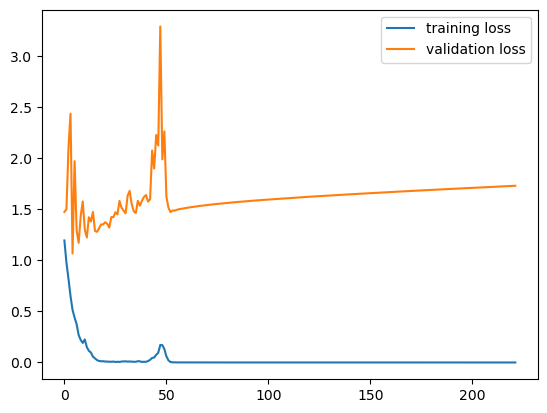

23
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
23
cd16
4608


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1739 loss_val: 1.1614 time: 7.4852s
 Epoch: 0010 loss_train: 0.5166 loss_val: 1.6962 time: 6.6727s
 Epoch: 0020 loss_train: 0.1820 loss_val: 2.1620 time: 7.0741s
 Epoch: 0030 loss_train: 0.0236 loss_val: 2.4945 time: 6.4430s
 Epoch: 0040 loss_train: 0.0077 loss_val: 2.5934 time: 7.3940s
 Epoch: 0050 loss_train: 0.0039 loss_val: 2.6039 time: 7.5519s
 Epoch: 0060 loss_train: 0.0014 loss_val: 2.6228 time: 8.3952s
 Epoch: 0070 loss_train: 0.0010 loss_val: 2.6665 time: 7.8627s
 Epoch: 0080 loss_train: 0.0011 loss_val: 2.7003 time: 8.5934s
 Epoch: 0090 loss_train: 0.0011 loss_val: 2.7300 time: 8.1139s
 Epoch: 0100 loss_train: 0.0009 loss_val: 2.7525 time: 8.2131s
 Epoch: 0110 loss_train: 0.0008 loss_val: 2.7731 time: 7.5697s
 Epoch: 0120 loss_train: 0.0009 loss_val: 2.8081 time: 5.9041s
 Epoch: 0130 loss_train: 0.0008 loss_val: 2.8142 time: 7.9560s
 Epoch: 0140 loss_train: 0.0008 loss_val: 2.8338 time: 6.8960s
 Epoch: 0150 loss_train: 0.0008 loss_val: 2.8543 time: 

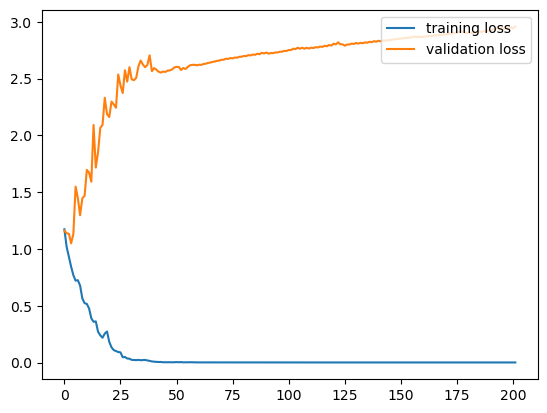

cd3
3822


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0367 loss_val: 1.0916 time: 5.8716s
 Epoch: 0010 loss_train: 0.0291 loss_val: 1.3595 time: 6.7142s
 Epoch: 0020 loss_train: 0.0373 loss_val: 1.9576 time: 6.4935s
 Epoch: 0030 loss_train: 0.0323 loss_val: 2.2090 time: 5.1503s
 Epoch: 0040 loss_train: 0.0007 loss_val: 1.5556 time: 6.4543s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.5665 time: 6.4537s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.5782 time: 6.8879s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5902 time: 5.8888s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.6021 time: 6.9325s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.6137 time: 6.4583s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6248 time: 6.1197s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6354 time: 3.9916s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6458 time: 5.3005s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6558 time: 6.6779s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6657 time: 6.3658s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6754 time: 

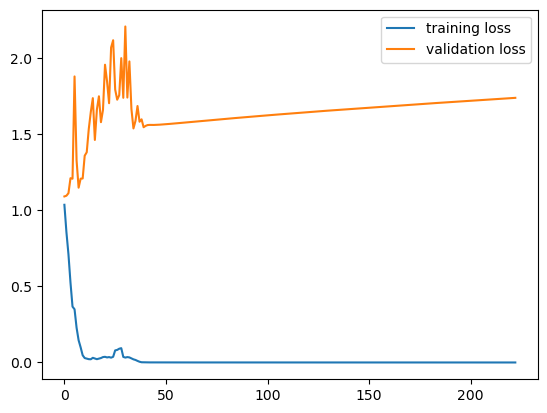

cd4
5637


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2040 loss_val: 1.3951 time: 7.3291s
 Epoch: 0010 loss_train: 0.3265 loss_val: 1.6930 time: 8.2688s
 Epoch: 0020 loss_train: 0.1365 loss_val: 2.1110 time: 8.6295s
 Epoch: 0030 loss_train: 0.0078 loss_val: 2.0645 time: 7.7523s
 Epoch: 0040 loss_train: 0.0038 loss_val: 2.1514 time: 8.7836s
 Epoch: 0050 loss_train: 0.0011 loss_val: 2.1706 time: 9.5900s
 Epoch: 0060 loss_train: 0.0007 loss_val: 2.2117 time: 9.1085s
 Epoch: 0070 loss_train: 0.0006 loss_val: 2.2479 time: 9.3981s
 Epoch: 0080 loss_train: 0.0005 loss_val: 2.2784 time: 8.2139s
 Epoch: 0090 loss_train: 0.0005 loss_val: 2.3106 time: 9.0884s
 Epoch: 0100 loss_train: 0.0004 loss_val: 2.3304 time: 8.3567s
 Epoch: 0110 loss_train: 0.0004 loss_val: 2.3619 time: 8.3044s
 Epoch: 0120 loss_train: 0.0005 loss_val: 2.3918 time: 8.5945s
 Epoch: 0130 loss_train: 0.0003 loss_val: 2.3883 time: 5.0941s
 Epoch: 0140 loss_train: 0.0003 loss_val: 2.4265 time: 8.6247s
 Epoch: 0150 loss_train: 0.0003 loss_val: 2.4519 time: 

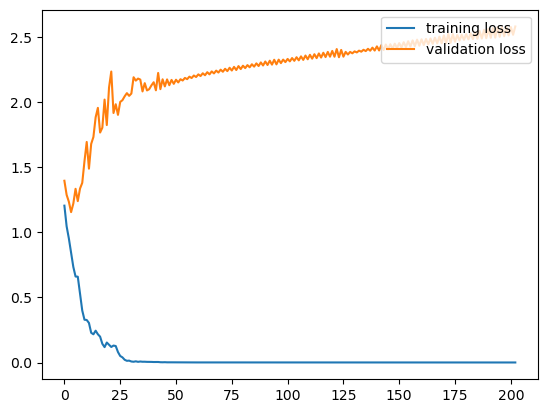

cd8
5659


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2180 loss_val: 1.5521 time: 8.7650s
 Epoch: 0010 loss_train: 0.1575 loss_val: 1.6005 time: 8.1473s
 Epoch: 0020 loss_train: 0.0086 loss_val: 1.8364 time: 8.0968s
 Epoch: 0030 loss_train: 0.0030 loss_val: 1.9285 time: 8.4686s
 Epoch: 0040 loss_train: 0.0007 loss_val: 1.9788 time: 8.8807s
 Epoch: 0050 loss_train: 0.0005 loss_val: 2.0291 time: 9.1594s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.0677 time: 8.8888s
 Epoch: 0070 loss_train: 0.0003 loss_val: 2.1003 time: 9.2950s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.1295 time: 9.2949s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.1559 time: 8.6573s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.1806 time: 9.2315s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.2040 time: 9.1204s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.2265 time: 10.0172s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.2477 time: 7.9224s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.2685 time: 9.0831s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.2888 time:

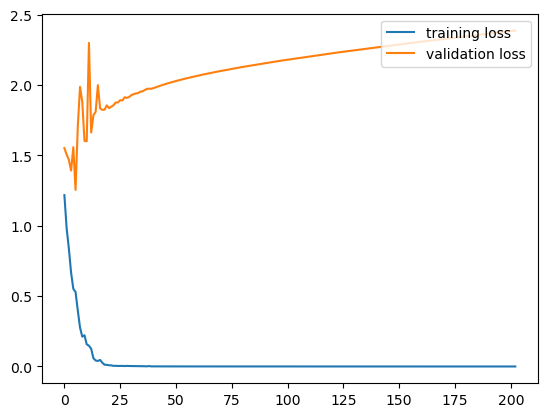

gh2ax
4938


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0442 loss_val: 1.7209 time: 6.3061s
 Epoch: 0010 loss_train: 0.0158 loss_val: 1.2484 time: 7.0055s
 Epoch: 0020 loss_train: 0.0009 loss_val: 1.1625 time: 7.4581s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.1981 time: 6.5893s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.2271 time: 7.7682s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.2518 time: 9.1065s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.2735 time: 7.0947s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.2928 time: 8.2925s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3105 time: 7.8438s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3270 time: 7.2121s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3425 time: 5.5581s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3571 time: 7.8471s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3711 time: 7.0083s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3843 time: 7.5674s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.3972 time: 7.9684s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4096 time: 

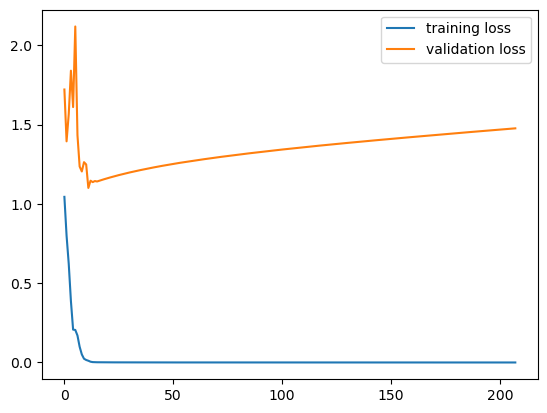

lamin
4939


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1665 loss_val: 1.4118 time: 7.5381s
 Epoch: 0010 loss_train: 0.0893 loss_val: 1.3814 time: 5.1781s
 Epoch: 0020 loss_train: 0.0038 loss_val: 1.3981 time: 6.7534s
 Epoch: 0030 loss_train: 0.0033 loss_val: 1.5210 time: 6.7971s
 Epoch: 0040 loss_train: 0.0115 loss_val: 1.5740 time: 8.4776s
 Epoch: 0050 loss_train: 0.0822 loss_val: 1.7870 time: 6.1066s
 Epoch: 0060 loss_train: 0.0005 loss_val: 1.5452 time: 7.7670s
 Epoch: 0070 loss_train: 0.0003 loss_val: 1.5735 time: 7.8965s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.5945 time: 7.9191s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.6117 time: 6.5252s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6268 time: 7.0430s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6406 time: 7.1804s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6530 time: 9.0645s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6648 time: 8.2238s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6760 time: 6.5554s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6866 time: 

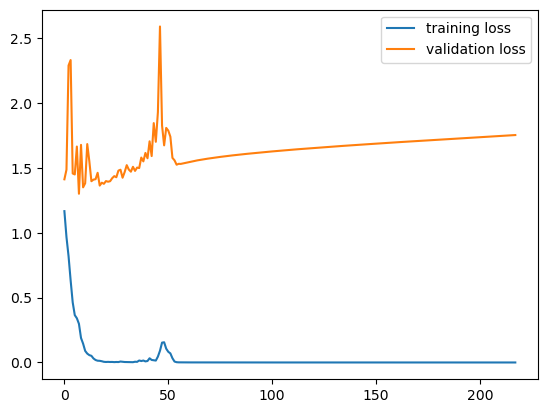

24
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
24
cd16
4555


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1195 loss_val: 1.2260 time: 7.5340s
 Epoch: 0010 loss_train: 0.4796 loss_val: 1.7765 time: 7.0533s
 Epoch: 0020 loss_train: 0.1749 loss_val: 2.4876 time: 7.7223s
 Epoch: 0030 loss_train: 0.0276 loss_val: 2.4524 time: 7.8286s
 Epoch: 0040 loss_train: 0.0217 loss_val: 2.6602 time: 7.0477s
 Epoch: 0050 loss_train: 0.0171 loss_val: 2.7854 time: 7.3822s
 Epoch: 0060 loss_train: 0.0291 loss_val: 3.0004 time: 7.3870s
 Epoch: 0070 loss_train: 0.0256 loss_val: 3.0587 time: 6.4960s
 Epoch: 0080 loss_train: 0.0266 loss_val: 3.1165 time: 5.8125s
 Epoch: 0090 loss_train: 0.0043 loss_val: 2.8640 time: 7.7402s
 Epoch: 0100 loss_train: 0.0004 loss_val: 2.8812 time: 7.7243s
 Epoch: 0110 loss_train: 0.0002 loss_val: 2.9234 time: 6.3137s
 Epoch: 0120 loss_train: 0.0002 loss_val: 2.9523 time: 6.1980s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.9753 time: 6.7224s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.9954 time: 8.3947s
 Epoch: 0150 loss_train: 0.0001 loss_val: 3.0133 time: 

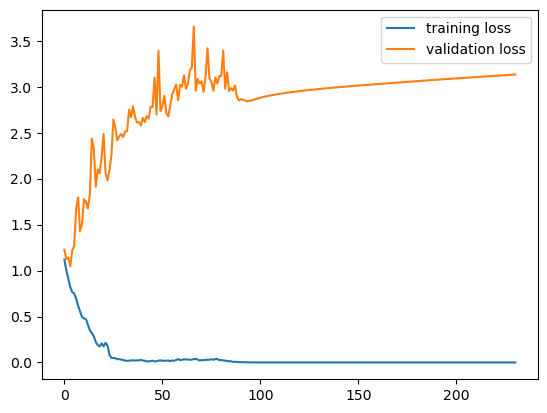

cd3
3760


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0282 loss_val: 1.1114 time: 4.7161s
 Epoch: 0010 loss_train: 0.0310 loss_val: 1.2718 time: 4.8338s
 Epoch: 0020 loss_train: 0.0246 loss_val: 1.6562 time: 6.0343s
 Epoch: 0030 loss_train: 0.0023 loss_val: 1.3188 time: 5.8953s
 Epoch: 0040 loss_train: 0.0006 loss_val: 1.3566 time: 5.7585s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.3812 time: 4.5853s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.4017 time: 5.6102s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4195 time: 6.2801s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4355 time: 6.2653s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.4501 time: 4.6581s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4634 time: 6.2647s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4760 time: 5.7854s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4879 time: 6.3423s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4993 time: 6.1851s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5101 time: 5.0500s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5207 time: 

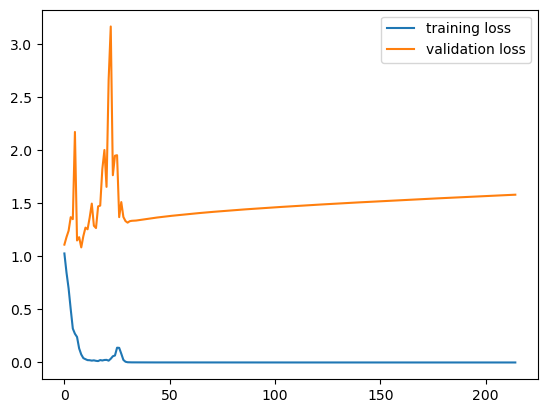

cd4
5580


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1921 loss_val: 1.4583 time: 7.9549s
 Epoch: 0010 loss_train: 0.3777 loss_val: 1.5674 time: 7.9763s
 Epoch: 0020 loss_train: 0.0775 loss_val: 1.9498 time: 8.4536s
 Epoch: 0030 loss_train: 0.0190 loss_val: 2.3726 time: 9.0983s
 Epoch: 0040 loss_train: 0.0287 loss_val: 2.6285 time: 8.5451s
 Epoch: 0050 loss_train: 0.0191 loss_val: 2.6156 time: 7.5647s
 Epoch: 0060 loss_train: 0.0004 loss_val: 2.6006 time: 9.5212s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.6186 time: 9.1874s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.6373 time: 9.8610s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.6547 time: 8.4547s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.6709 time: 8.5037s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.6870 time: 7.5670s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.7025 time: 5.0771s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.7180 time: 6.2078s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.7332 time: 8.6950s
 Epoch: 0150 loss_train: 0.0000 loss_val: 2.7484 time: 

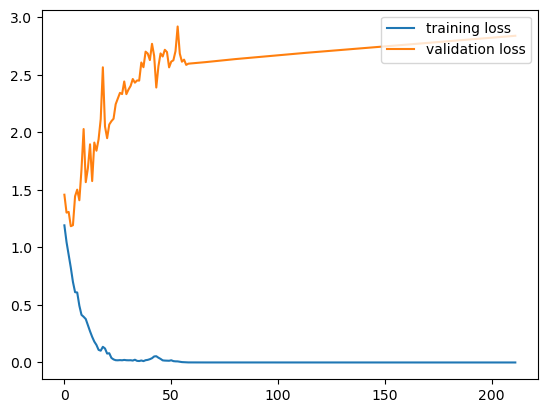

cd8
5604


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1911 loss_val: 1.7987 time: 7.4063s
 Epoch: 0010 loss_train: 0.1547 loss_val: 1.6509 time: 8.1795s
 Epoch: 0020 loss_train: 0.0115 loss_val: 2.1629 time: 6.0966s
 Epoch: 0030 loss_train: 0.0025 loss_val: 2.0492 time: 8.0773s
 Epoch: 0040 loss_train: 0.0022 loss_val: 2.1153 time: 9.9287s
 Epoch: 0050 loss_train: 0.0014 loss_val: 2.1528 time: 9.8216s
 Epoch: 0060 loss_train: 0.0014 loss_val: 2.2005 time: 9.2913s
 Epoch: 0070 loss_train: 0.0051 loss_val: 2.2159 time: 7.7302s
 Epoch: 0080 loss_train: 0.0036 loss_val: 2.2906 time: 7.7590s
 Epoch: 0090 loss_train: 0.0033 loss_val: 2.4095 time: 7.0647s
 Epoch: 0100 loss_train: 0.0011 loss_val: 2.3409 time: 7.7801s
 Epoch: 0110 loss_train: 0.0006 loss_val: 2.3622 time: 9.0136s
 Epoch: 0120 loss_train: 0.0007 loss_val: 2.4075 time: 8.2115s
 Epoch: 0130 loss_train: 0.0006 loss_val: 2.4281 time: 8.1904s
 Epoch: 0140 loss_train: 0.0006 loss_val: 2.4502 time: 8.4462s
 Epoch: 0150 loss_train: 0.0006 loss_val: 2.4750 time: 

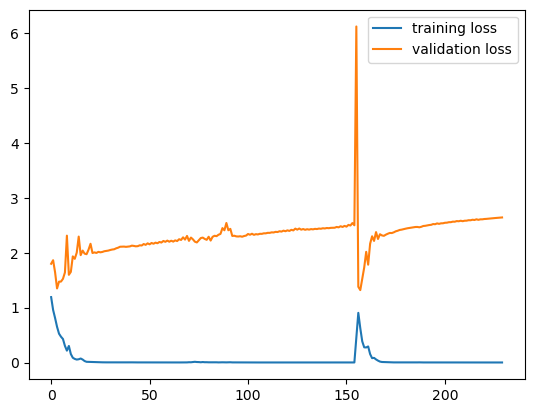

gh2ax
4837


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0156 loss_val: 1.8581 time: 5.6705s
 Epoch: 0010 loss_train: 0.0173 loss_val: 1.0633 time: 8.1116s
 Epoch: 0020 loss_train: 0.0007 loss_val: 1.0230 time: 7.9173s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.0548 time: 7.0697s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.0800 time: 8.2889s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.1013 time: 7.7401s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.1201 time: 8.1052s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.1368 time: 6.9921s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.1520 time: 8.8832s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.1662 time: 6.7412s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.1795 time: 7.5888s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.1919 time: 7.8901s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.2038 time: 7.4059s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.2151 time: 8.0664s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.2260 time: 4.7717s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.2366 time: 

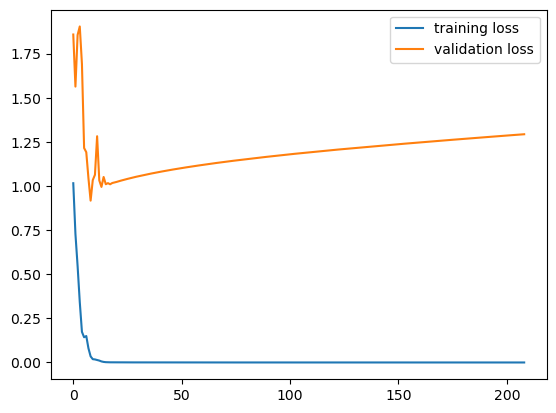

lamin
4838


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1249 loss_val: 1.6150 time: 6.4494s
 Epoch: 0010 loss_train: 0.0923 loss_val: 1.3275 time: 7.2945s
 Epoch: 0020 loss_train: 0.0109 loss_val: 1.1309 time: 4.7181s
 Epoch: 0030 loss_train: 0.0074 loss_val: 1.3354 time: 7.0638s
 Epoch: 0040 loss_train: 0.0014 loss_val: 1.2586 time: 7.0524s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.2660 time: 7.3468s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.2857 time: 6.8049s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3026 time: 8.0450s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.3176 time: 7.7118s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3314 time: 6.0375s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3441 time: 5.8193s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3562 time: 6.2678s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3677 time: 8.3213s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3787 time: 7.4308s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.3895 time: 9.1250s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.3999 time: 

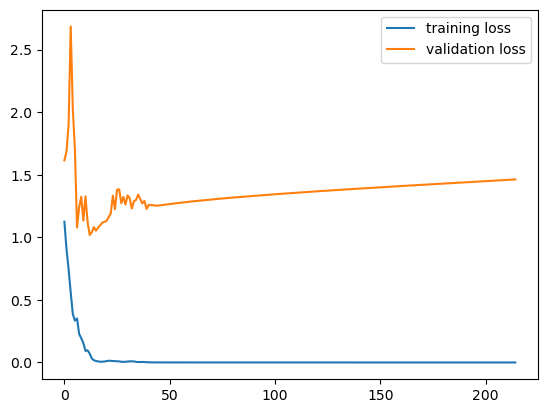

25
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
25
cd16
4490


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1411 loss_val: 1.2495 time: 8.5014s
 Epoch: 0010 loss_train: 0.4614 loss_val: 2.2622 time: 7.4967s
 Epoch: 0020 loss_train: 0.1166 loss_val: 2.5351 time: 6.9190s
 Epoch: 0030 loss_train: 0.0442 loss_val: 2.8826 time: 6.1981s
 Epoch: 0040 loss_train: 0.0205 loss_val: 3.1012 time: 8.0419s
 Epoch: 0050 loss_train: 0.0308 loss_val: 2.8955 time: 7.5439s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.6708 time: 7.0261s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.6976 time: 6.6221s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.7219 time: 7.2376s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.7439 time: 7.8323s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.7639 time: 7.1822s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.7829 time: 8.7906s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.8011 time: 7.3576s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.8185 time: 7.1819s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.8354 time: 6.7376s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.8519 time: 

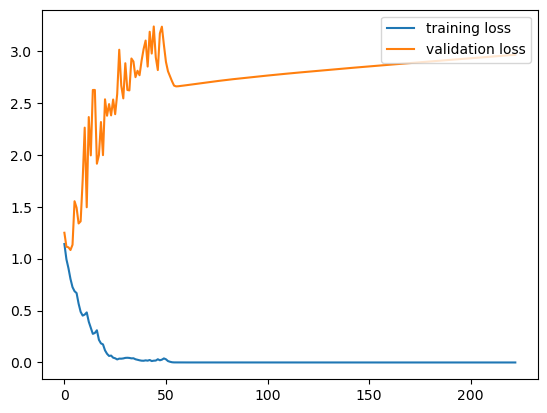

cd3
3802


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0129 loss_val: 1.1059 time: 5.4941s
 Epoch: 0010 loss_train: 0.0826 loss_val: 1.1875 time: 5.9467s
 Epoch: 0020 loss_train: 0.0033 loss_val: 1.1689 time: 6.2264s
 Epoch: 0030 loss_train: 0.0007 loss_val: 1.1806 time: 5.8489s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.2059 time: 6.0419s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.2274 time: 6.8873s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.2464 time: 6.7884s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.2633 time: 7.5256s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.2787 time: 5.6413s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.2928 time: 7.3313s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3061 time: 8.1740s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3185 time: 6.7456s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3303 time: 5.8774s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3416 time: 7.1033s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.3525 time: 4.6393s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.3629 time: 

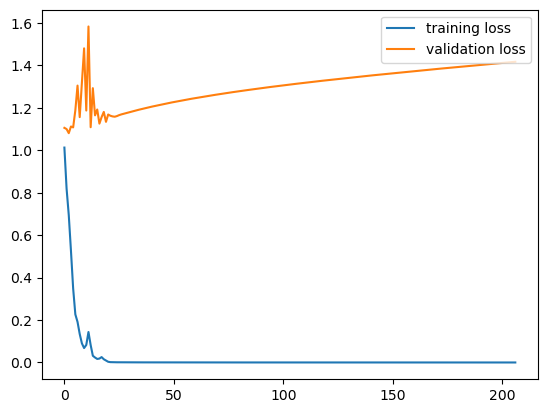

cd4
5518


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1768 loss_val: 1.5201 time: 9.9346s
 Epoch: 0010 loss_train: 0.2818 loss_val: 1.6104 time: 9.1282s
 Epoch: 0020 loss_train: 0.0518 loss_val: 2.1324 time: 9.5762s
 Epoch: 0030 loss_train: 0.0510 loss_val: 2.3710 time: 8.4301s
 Epoch: 0040 loss_train: 0.0005 loss_val: 2.3952 time: 8.8151s
 Epoch: 0050 loss_train: 0.0003 loss_val: 2.4247 time: 7.6946s
 Epoch: 0060 loss_train: 0.0002 loss_val: 2.4534 time: 8.3509s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.4800 time: 9.7033s
 Epoch: 0080 loss_train: 0.0001 loss_val: 2.5046 time: 8.5983s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.5276 time: 8.2281s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.5496 time: 6.8994s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.5706 time: 7.6810s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.5912 time: 9.1710s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.6110 time: 8.1617s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.6305 time: 8.7708s
 Epoch: 0150 loss_train: 0.0000 loss_val: 2.6496 time: 

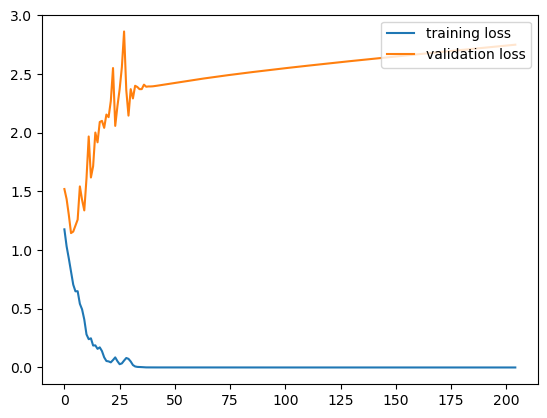

cd8
5545


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2038 loss_val: 1.5163 time: 8.8167s
 Epoch: 0010 loss_train: 0.0976 loss_val: 1.9795 time: 8.7552s
 Epoch: 0020 loss_train: 0.0100 loss_val: 1.9244 time: 9.6378s
 Epoch: 0030 loss_train: 0.0007 loss_val: 1.9763 time: 9.1343s
 Epoch: 0040 loss_train: 0.0005 loss_val: 2.0206 time: 8.8020s
 Epoch: 0050 loss_train: 0.0003 loss_val: 2.0562 time: 10.7890s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.0870 time: 7.5574s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.1147 time: 9.0163s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.1402 time: 9.9341s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.1640 time: 9.7426s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.1864 time: 7.2074s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.2078 time: 7.5383s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.2285 time: 8.7971s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.2485 time: 9.2518s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.2677 time: 9.4447s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.2868 time:

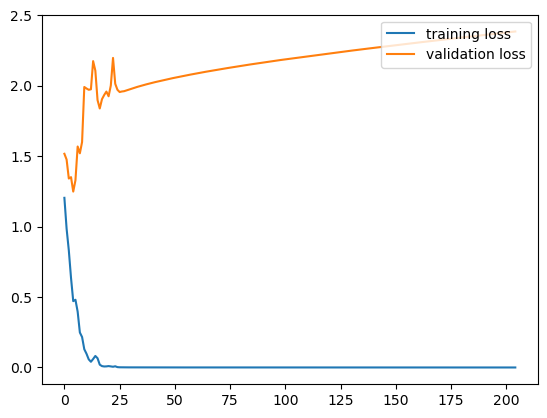

gh2ax
4931


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0108 loss_val: 1.8189 time: 6.6902s
 Epoch: 0010 loss_train: 0.0182 loss_val: 1.1680 time: 7.7661s
 Epoch: 0020 loss_train: 0.0007 loss_val: 1.1323 time: 7.4277s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.1751 time: 8.9076s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.2066 time: 7.0699s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.2326 time: 6.5718s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.2551 time: 6.8742s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.2751 time: 5.5213s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.2933 time: 7.7455s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3103 time: 7.5568s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3261 time: 9.6916s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3410 time: 8.6053s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3552 time: 6.3637s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3690 time: 7.5052s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.3821 time: 7.6125s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.3948 time: 

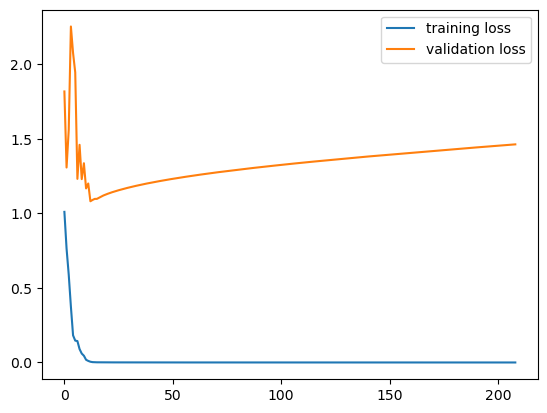

lamin
4932


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1828 loss_val: 1.7319 time: 8.7867s
 Epoch: 0010 loss_train: 0.0575 loss_val: 1.2314 time: 9.3165s
 Epoch: 0020 loss_train: 0.0074 loss_val: 1.3116 time: 7.3520s
 Epoch: 0030 loss_train: 0.0133 loss_val: 1.4504 time: 8.1019s
 Epoch: 0040 loss_train: 0.0019 loss_val: 1.4439 time: 8.4368s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.4179 time: 7.6510s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.4268 time: 7.9534s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4369 time: 8.0880s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.4472 time: 7.0723s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4575 time: 8.4309s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4676 time: 6.6488s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4775 time: 7.8432s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4871 time: 9.0594s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4967 time: 7.3147s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5061 time: 7.9444s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5154 time: 

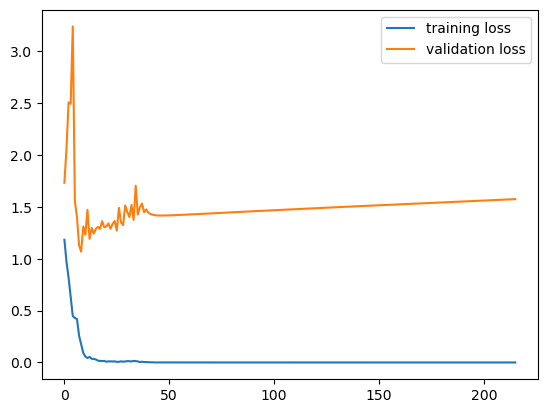

26
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
26
cd16
4629


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1699 loss_val: 1.1853 time: 8.0515s
 Epoch: 0010 loss_train: 0.5237 loss_val: 1.5381 time: 8.1103s
 Epoch: 0020 loss_train: 0.2255 loss_val: 2.3408 time: 9.0345s
 Epoch: 0030 loss_train: 0.0132 loss_val: 2.3704 time: 8.3862s
 Epoch: 0040 loss_train: 0.0046 loss_val: 2.4353 time: 6.8594s
 Epoch: 0050 loss_train: 0.0030 loss_val: 2.4927 time: 6.4745s
 Epoch: 0060 loss_train: 0.0018 loss_val: 2.5206 time: 7.8352s
 Epoch: 0070 loss_train: 0.0021 loss_val: 2.5638 time: 7.6645s
 Epoch: 0080 loss_train: 0.0016 loss_val: 2.5777 time: 7.8950s
 Epoch: 0090 loss_train: 0.0021 loss_val: 2.6027 time: 8.2821s
 Epoch: 0100 loss_train: 0.0016 loss_val: 2.6292 time: 7.3324s
 Epoch: 0110 loss_train: 0.0014 loss_val: 2.6542 time: 8.1882s
 Epoch: 0120 loss_train: 0.0016 loss_val: 2.6828 time: 7.6778s
 Epoch: 0130 loss_train: 0.0014 loss_val: 2.6957 time: 7.5275s
 Epoch: 0140 loss_train: 0.0020 loss_val: 2.7666 time: 6.9996s
 Epoch: 0150 loss_train: 0.0013 loss_val: 2.7278 time: 

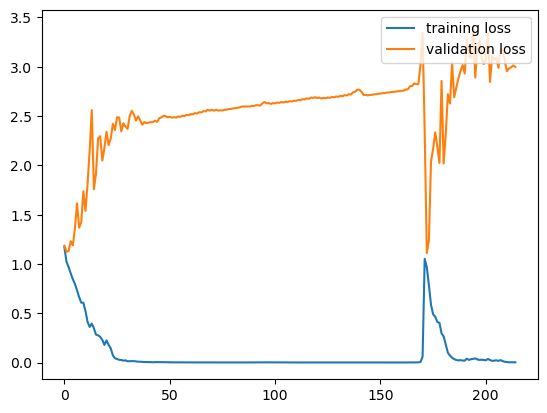

cd3
3806


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0135 loss_val: 1.0918 time: 4.5195s
 Epoch: 0010 loss_train: 0.0785 loss_val: 1.2519 time: 5.8312s
 Epoch: 0020 loss_train: 0.0024 loss_val: 1.3190 time: 7.1914s
 Epoch: 0030 loss_train: 0.0007 loss_val: 1.3485 time: 5.6378s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.3813 time: 6.5324s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.4081 time: 5.1458s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.4314 time: 3.4226s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4517 time: 4.2484s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4702 time: 6.3958s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.4874 time: 6.4249s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5032 time: 7.0194s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5181 time: 6.2283s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5321 time: 7.2284s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5456 time: 6.7638s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5584 time: 6.6345s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5707 time: 

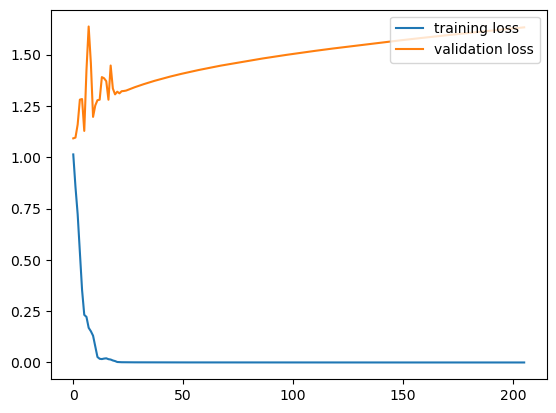

cd4
5663


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1859 loss_val: 1.4993 time: 11.0277s
 Epoch: 0010 loss_train: 0.3533 loss_val: 1.6178 time: 10.9459s
 Epoch: 0020 loss_train: 0.1144 loss_val: 2.2005 time: 9.6012s
 Epoch: 0030 loss_train: 0.0247 loss_val: 2.5377 time: 5.3367s
 Epoch: 0040 loss_train: 0.0038 loss_val: 2.4742 time: 10.1413s
 Epoch: 0050 loss_train: 0.0006 loss_val: 2.4359 time: 9.4088s
 Epoch: 0060 loss_train: 0.0006 loss_val: 2.4732 time: 10.0602s
 Epoch: 0070 loss_train: 0.0004 loss_val: 2.5021 time: 10.4547s
 Epoch: 0080 loss_train: 0.0005 loss_val: 2.5324 time: 9.3506s
 Epoch: 0090 loss_train: 0.0004 loss_val: 2.5558 time: 8.7435s
 Epoch: 0100 loss_train: 0.0004 loss_val: 2.5847 time: 10.7936s
 Epoch: 0110 loss_train: 0.0003 loss_val: 2.6048 time: 8.9352s
 Epoch: 0120 loss_train: 0.0004 loss_val: 2.6300 time: 8.1026s
 Epoch: 0130 loss_train: 0.0003 loss_val: 2.6501 time: 5.1484s
 Epoch: 0140 loss_train: 0.0008 loss_val: 2.7245 time: 9.9997s
 Epoch: 0150 loss_train: 0.1404 loss_val: 2.1729 

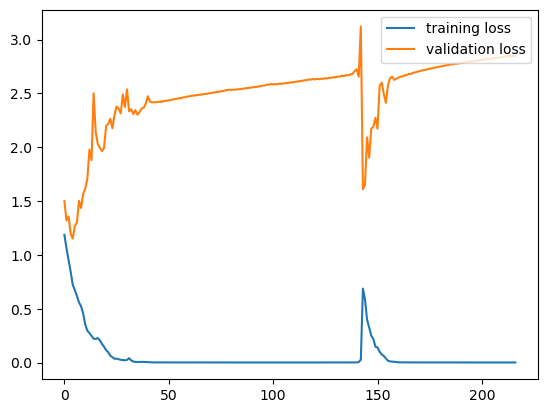

cd8
5687


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2355 loss_val: 1.6694 time: 12.1717s
 Epoch: 0010 loss_train: 0.2197 loss_val: 1.8090 time: 5.8687s
 Epoch: 0020 loss_train: 0.0073 loss_val: 1.9419 time: 8.5271s
 Epoch: 0030 loss_train: 0.0011 loss_val: 2.0463 time: 10.7230s
 Epoch: 0040 loss_train: 0.0006 loss_val: 2.1102 time: 9.7692s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.1583 time: 11.5934s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.2030 time: 6.0111s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.2398 time: 10.9089s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.2723 time: 7.0706s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.3015 time: 9.4731s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.3289 time: 8.1419s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.3546 time: 6.5655s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.3789 time: 6.3814s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.4024 time: 9.2884s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.4251 time: 10.5813s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.4469 t

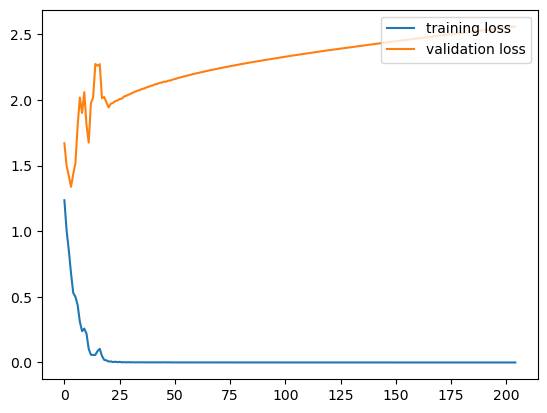

gh2ax
4889


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0839 loss_val: 1.5017 time: 8.3046s
 Epoch: 0010 loss_train: 0.0125 loss_val: 1.0981 time: 8.5633s
 Epoch: 0020 loss_train: 0.0011 loss_val: 1.1824 time: 8.2229s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.2298 time: 8.0732s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.2647 time: 9.0140s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.2935 time: 7.4708s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3181 time: 6.2017s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3399 time: 7.6391s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3595 time: 6.7600s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3776 time: 7.5200s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3945 time: 7.7194s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4104 time: 7.6185s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4255 time: 8.1364s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4400 time: 7.6737s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4539 time: 7.4891s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4673 time: 

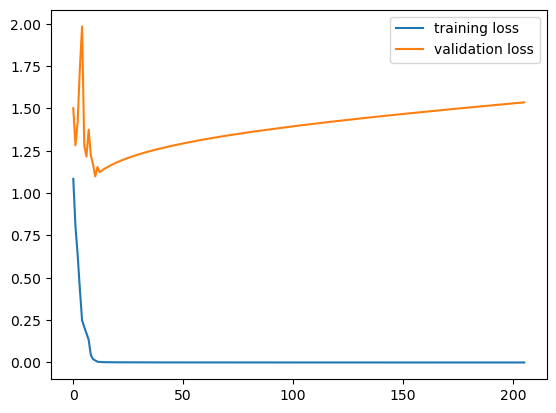

lamin
4890


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1911 loss_val: 1.3514 time: 7.0108s
 Epoch: 0010 loss_train: 0.1383 loss_val: 1.2698 time: 5.9443s
 Epoch: 0020 loss_train: 0.0179 loss_val: 1.3690 time: 7.2146s
 Epoch: 0030 loss_train: 0.0044 loss_val: 1.4361 time: 6.9814s
 Epoch: 0040 loss_train: 0.0012 loss_val: 1.4186 time: 8.3180s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.4448 time: 6.2327s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.4645 time: 8.2160s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4820 time: 7.7142s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4978 time: 6.4424s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5126 time: 7.4181s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5262 time: 7.0500s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5393 time: 7.4114s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5519 time: 9.0701s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5640 time: 8.1615s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5758 time: 8.4554s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5872 time: 

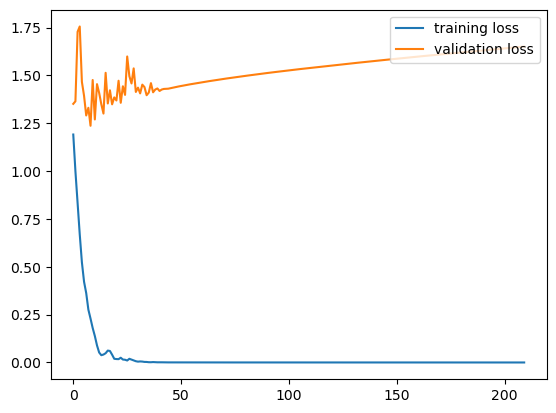

27
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
27
cd16
4560


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1512 loss_val: 1.2404 time: 7.8420s
 Epoch: 0010 loss_train: 0.4358 loss_val: 1.6299 time: 7.3736s
 Epoch: 0020 loss_train: 0.0772 loss_val: 1.9753 time: 7.7405s
 Epoch: 0030 loss_train: 0.0469 loss_val: 2.4475 time: 7.9604s
 Epoch: 0040 loss_train: 0.0414 loss_val: 2.9127 time: 7.0756s
 Epoch: 0050 loss_train: 0.0070 loss_val: 2.4147 time: 7.8266s
 Epoch: 0060 loss_train: 0.0013 loss_val: 2.4306 time: 7.7389s
 Epoch: 0070 loss_train: 0.0024 loss_val: 2.4814 time: 7.7442s
 Epoch: 0080 loss_train: 0.0008 loss_val: 2.4895 time: 5.9100s
 Epoch: 0090 loss_train: 0.0008 loss_val: 2.5145 time: 8.4300s
 Epoch: 0100 loss_train: 0.0006 loss_val: 2.5363 time: 7.9927s
 Epoch: 0110 loss_train: 0.0006 loss_val: 2.5527 time: 7.5058s
 Epoch: 0120 loss_train: 0.0006 loss_val: 2.5725 time: 6.0256s
 Epoch: 0130 loss_train: 0.0006 loss_val: 2.5902 time: 7.2768s
 Epoch: 0140 loss_train: 0.0005 loss_val: 2.5987 time: 9.0354s
 Epoch: 0150 loss_train: 0.0005 loss_val: 2.6206 time: 

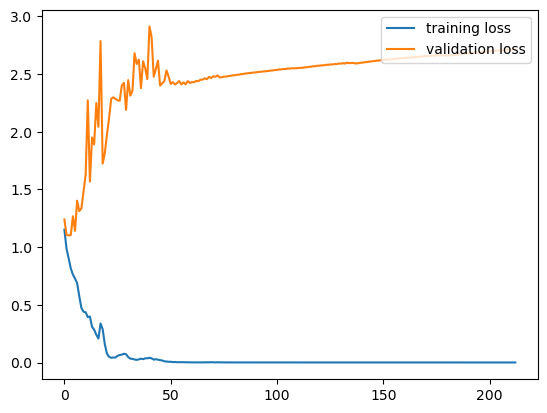

cd3
3772


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0443 loss_val: 1.1040 time: 6.9528s
 Epoch: 0010 loss_train: 0.0337 loss_val: 1.2423 time: 6.9460s
 Epoch: 0020 loss_train: 0.0120 loss_val: 1.9207 time: 7.7629s
 Epoch: 0030 loss_train: 0.0314 loss_val: 1.5688 time: 6.9636s
 Epoch: 0040 loss_train: 0.0769 loss_val: 2.7125 time: 5.9558s
 Epoch: 0050 loss_train: 0.0068 loss_val: 1.5803 time: 7.2218s
 Epoch: 0060 loss_train: 0.0004 loss_val: 1.5680 time: 7.3027s
 Epoch: 0070 loss_train: 0.0003 loss_val: 1.5820 time: 7.1440s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.5945 time: 6.7293s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.6057 time: 6.3124s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6160 time: 6.4333s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6257 time: 6.1948s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6349 time: 6.3685s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6438 time: 5.9500s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6526 time: 4.6203s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6609 time: 

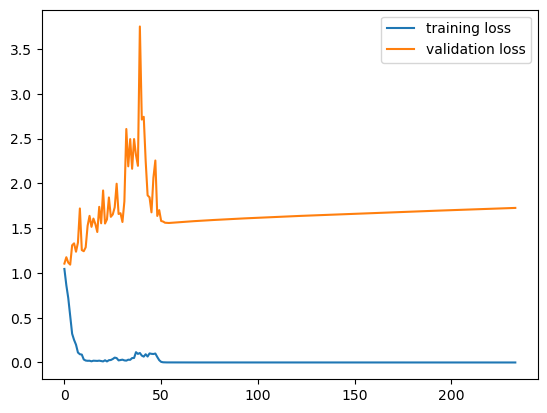

cd4
5602


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2089 loss_val: 1.4846 time: 7.0849s
 Epoch: 0010 loss_train: 0.3123 loss_val: 1.4857 time: 8.6843s
 Epoch: 0020 loss_train: 0.0643 loss_val: 1.8411 time: 8.7344s
 Epoch: 0030 loss_train: 0.0031 loss_val: 2.1013 time: 8.4113s
 Epoch: 0040 loss_train: 0.0009 loss_val: 2.1832 time: 9.4429s
 Epoch: 0050 loss_train: 0.0008 loss_val: 2.2353 time: 8.3819s
 Epoch: 0060 loss_train: 0.0006 loss_val: 2.2778 time: 8.1478s
 Epoch: 0070 loss_train: 0.0005 loss_val: 2.3057 time: 8.0606s
 Epoch: 0080 loss_train: 0.0005 loss_val: 2.3508 time: 8.7911s
 Epoch: 0090 loss_train: 0.0004 loss_val: 2.3784 time: 9.0607s
 Epoch: 0100 loss_train: 0.0005 loss_val: 2.4213 time: 8.9275s
 Epoch: 0110 loss_train: 0.0004 loss_val: 2.4308 time: 8.5425s
 Epoch: 0120 loss_train: 0.0004 loss_val: 2.4665 time: 8.1085s
 Epoch: 0130 loss_train: 0.0004 loss_val: 2.5079 time: 7.7038s
 Epoch: 0140 loss_train: 0.0003 loss_val: 2.4987 time: 9.7026s
 Epoch: 0150 loss_train: 0.0003 loss_val: 2.5373 time: 

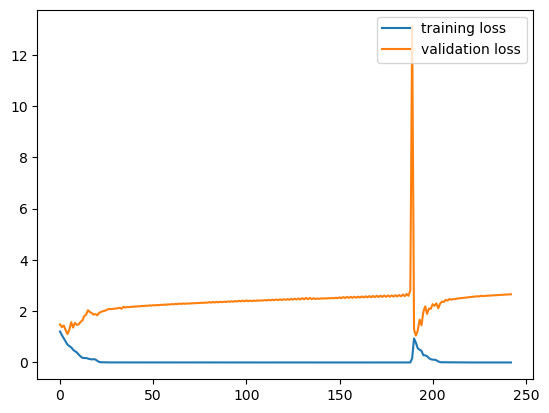

cd8
5625


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2356 loss_val: 1.7285 time: 9.1522s
 Epoch: 0010 loss_train: 0.2005 loss_val: 1.7147 time: 10.2136s
 Epoch: 0020 loss_train: 0.0057 loss_val: 1.8507 time: 10.4187s
 Epoch: 0030 loss_train: 0.0053 loss_val: 1.9470 time: 11.1433s
 Epoch: 0040 loss_train: 0.0011 loss_val: 1.9836 time: 10.0353s
 Epoch: 0050 loss_train: 0.0008 loss_val: 2.0334 time: 9.9429s
 Epoch: 0060 loss_train: 0.0007 loss_val: 2.0764 time: 10.0759s
 Epoch: 0070 loss_train: 0.0006 loss_val: 2.1042 time: 10.1052s
 Epoch: 0080 loss_train: 0.0005 loss_val: 2.1386 time: 10.3781s
 Epoch: 0090 loss_train: 0.0005 loss_val: 2.1733 time: 9.8413s
 Epoch: 0100 loss_train: 0.0007 loss_val: 2.2430 time: 9.8470s
 Epoch: 0110 loss_train: 0.4685 loss_val: 1.8372 time: 10.7811s
 Epoch: 0120 loss_train: 0.0056 loss_val: 2.1404 time: 10.2206s
 Epoch: 0130 loss_train: 0.0012 loss_val: 2.2158 time: 8.4065s
 Epoch: 0140 loss_train: 0.0006 loss_val: 2.2605 time: 8.0257s
 Epoch: 0150 loss_train: 0.0005 loss_val: 2.29

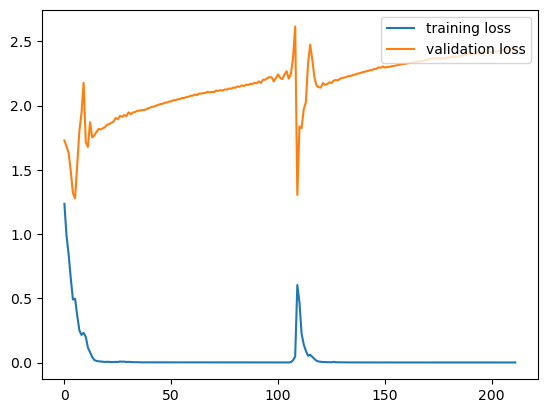

gh2ax
4892


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0562 loss_val: 1.5894 time: 7.2367s
 Epoch: 0010 loss_train: 0.0250 loss_val: 1.2738 time: 8.5598s
 Epoch: 0020 loss_train: 0.0009 loss_val: 1.2082 time: 8.4724s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.2440 time: 7.8815s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.2725 time: 8.4337s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.2964 time: 8.2011s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3175 time: 8.0646s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3366 time: 8.4565s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3539 time: 7.5593s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3701 time: 9.0644s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3853 time: 7.7685s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3996 time: 7.6026s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4134 time: 8.3577s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4266 time: 8.3309s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.4394 time: 7.2118s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4518 time: 

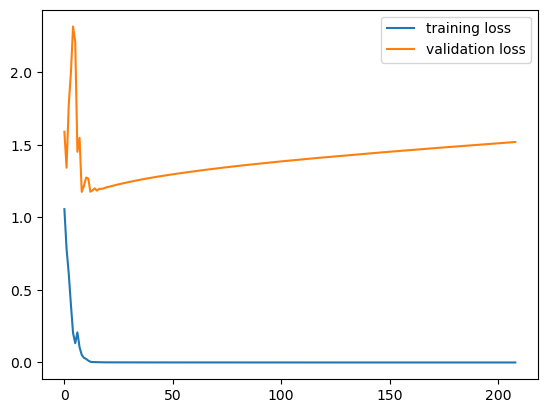

lamin
4893


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1835 loss_val: 1.5836 time: 9.4018s
 Epoch: 0010 loss_train: 0.1999 loss_val: 1.6112 time: 8.5227s
 Epoch: 0020 loss_train: 0.0079 loss_val: 1.2970 time: 8.2254s
 Epoch: 0030 loss_train: 0.0091 loss_val: 1.5506 time: 8.3484s
 Epoch: 0040 loss_train: 0.0104 loss_val: 1.6142 time: 8.3558s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.4773 time: 9.9964s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.4910 time: 7.4249s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5037 time: 8.5687s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.5159 time: 8.4873s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5273 time: 9.5086s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5384 time: 7.2672s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5490 time: 8.5037s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5593 time: 8.9781s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5695 time: 8.0166s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5794 time: 8.4026s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5891 time: 

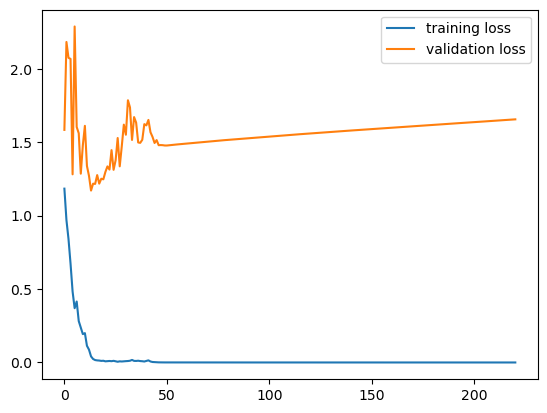

28
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
28
cd16
4544


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1381 loss_val: 1.1876 time: 8.7404s
 Epoch: 0010 loss_train: 0.4610 loss_val: 1.5804 time: 8.9275s
 Epoch: 0020 loss_train: 0.0935 loss_val: 2.5051 time: 9.1649s
 Epoch: 0030 loss_train: 0.0410 loss_val: 2.7736 time: 9.0022s
 Epoch: 0040 loss_train: 0.0238 loss_val: 2.8201 time: 8.2382s
 Epoch: 0050 loss_train: 0.0201 loss_val: 2.9291 time: 8.0533s
 Epoch: 0060 loss_train: 0.0212 loss_val: 2.7413 time: 8.1475s
 Epoch: 0070 loss_train: 0.0026 loss_val: 2.7259 time: 8.4259s
 Epoch: 0080 loss_train: 0.0023 loss_val: 2.7607 time: 9.6399s
 Epoch: 0090 loss_train: 0.0018 loss_val: 2.7891 time: 8.6562s
 Epoch: 0100 loss_train: 0.0034 loss_val: 2.8377 time: 8.4153s
 Epoch: 0110 loss_train: 0.0017 loss_val: 2.8459 time: 9.3487s
 Epoch: 0120 loss_train: 0.0014 loss_val: 2.8509 time: 8.3483s
 Epoch: 0130 loss_train: 0.0017 loss_val: 2.9103 time: 8.1283s
 Epoch: 0140 loss_train: 0.0015 loss_val: 2.8847 time: 8.4629s
 Epoch: 0150 loss_train: 0.0014 loss_val: 2.9104 time: 

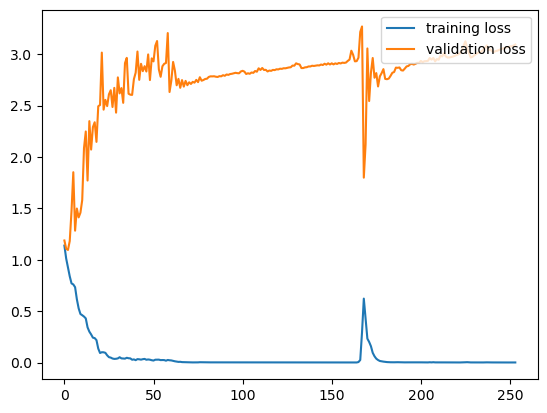

cd3
3781


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0341 loss_val: 1.1055 time: 6.9767s
 Epoch: 0010 loss_train: 0.0262 loss_val: 1.1379 time: 6.9220s
 Epoch: 0020 loss_train: 0.0167 loss_val: 1.5296 time: 6.9670s
 Epoch: 0030 loss_train: 0.1055 loss_val: 2.0320 time: 7.2997s
 Epoch: 0040 loss_train: 0.0010 loss_val: 1.4113 time: 6.4817s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.4177 time: 6.8237s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.4332 time: 6.2953s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4477 time: 5.9983s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4610 time: 6.5127s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.4734 time: 5.5988s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4851 time: 7.8375s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4961 time: 5.9251s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5066 time: 6.8910s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5167 time: 5.9597s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5265 time: 6.9881s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5359 time: 

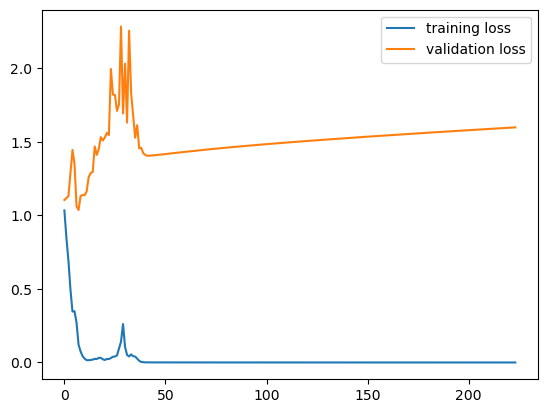

cd4
5579


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2074 loss_val: 1.7000 time: 8.8562s
 Epoch: 0010 loss_train: 0.3768 loss_val: 1.3804 time: 10.7309s
 Epoch: 0020 loss_train: 0.0697 loss_val: 2.0775 time: 10.0993s
 Epoch: 0030 loss_train: 0.0157 loss_val: 2.3405 time: 9.3591s
 Epoch: 0040 loss_train: 0.0074 loss_val: 2.5230 time: 11.4396s
 Epoch: 0050 loss_train: 0.0128 loss_val: 2.4801 time: 10.1581s
 Epoch: 0060 loss_train: 0.0244 loss_val: 2.8006 time: 8.6591s
 Epoch: 0070 loss_train: 0.0450 loss_val: 2.5352 time: 8.3591s
 Epoch: 0080 loss_train: 0.0006 loss_val: 2.5378 time: 9.6245s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.5588 time: 9.6139s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.5835 time: 9.3102s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.6041 time: 9.7916s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.6224 time: 9.2473s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.6397 time: 7.2227s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.6558 time: 10.0821s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.6712 t

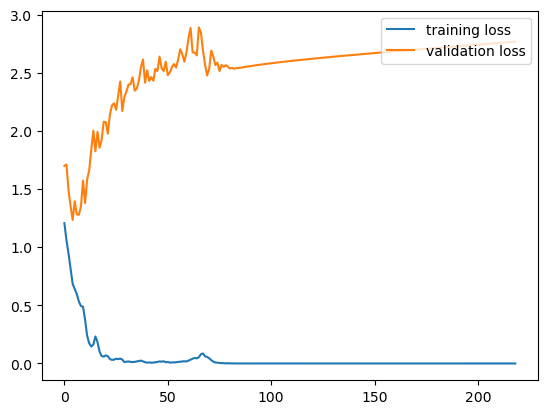

cd8
5605


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1981 loss_val: 1.6069 time: 8.3357s
 Epoch: 0010 loss_train: 0.1613 loss_val: 1.7918 time: 10.3583s
 Epoch: 0020 loss_train: 0.0125 loss_val: 2.0032 time: 10.9669s
 Epoch: 0030 loss_train: 0.0235 loss_val: 2.6515 time: 9.0738s
 Epoch: 0040 loss_train: 0.0074 loss_val: 2.1978 time: 8.6073s
 Epoch: 0050 loss_train: 0.0013 loss_val: 2.2042 time: 9.8430s
 Epoch: 0060 loss_train: 0.0006 loss_val: 2.2309 time: 8.4885s
 Epoch: 0070 loss_train: 0.0005 loss_val: 2.2545 time: 8.9529s
 Epoch: 0080 loss_train: 0.0005 loss_val: 2.2750 time: 9.2746s
 Epoch: 0090 loss_train: 0.0004 loss_val: 2.2914 time: 9.1353s
 Epoch: 0100 loss_train: 0.0004 loss_val: 2.3121 time: 9.9137s
 Epoch: 0110 loss_train: 0.0004 loss_val: 2.3300 time: 11.1203s
 Epoch: 0120 loss_train: 0.0003 loss_val: 2.3390 time: 6.7425s
 Epoch: 0130 loss_train: 0.0003 loss_val: 2.3606 time: 8.9154s
 Epoch: 0140 loss_train: 0.0003 loss_val: 2.3787 time: 8.6112s
 Epoch: 0150 loss_train: 0.0004 loss_val: 2.3967 tim

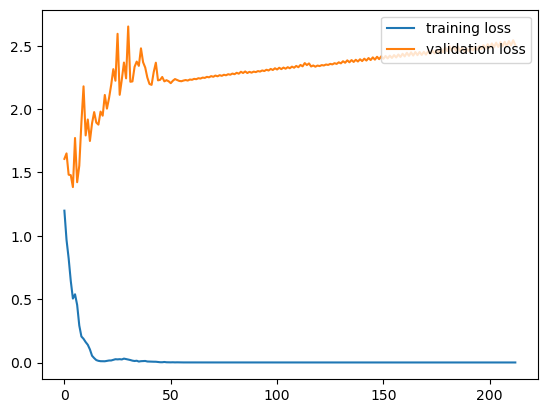

gh2ax
4926


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0408 loss_val: 1.7498 time: 8.5469s
 Epoch: 0010 loss_train: 0.0193 loss_val: 1.4179 time: 6.4332s
 Epoch: 0020 loss_train: 0.0008 loss_val: 1.1551 time: 5.9465s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.1932 time: 7.1798s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.2221 time: 8.7352s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.2462 time: 7.9743s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.2673 time: 10.0208s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.2863 time: 9.2858s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3036 time: 7.2154s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3195 time: 6.6639s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3347 time: 8.3696s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3490 time: 7.9782s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3627 time: 6.2386s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3759 time: 6.8453s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.3888 time: 8.2965s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4012 time:

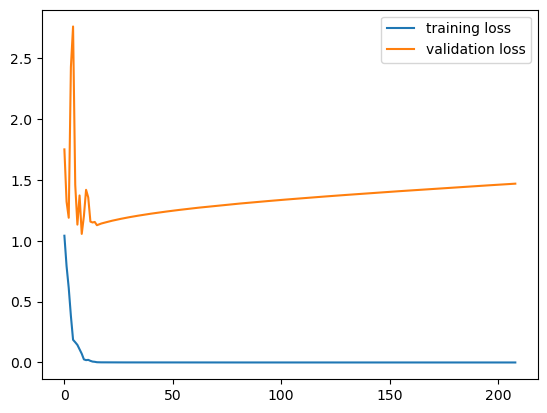

lamin
4927


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2088 loss_val: 1.4824 time: 5.6997s
 Epoch: 0010 loss_train: 0.1560 loss_val: 1.3659 time: 7.2763s
 Epoch: 0020 loss_train: 0.0107 loss_val: 1.2815 time: 6.6798s
 Epoch: 0030 loss_train: 0.0060 loss_val: 1.3876 time: 7.2540s
 Epoch: 0040 loss_train: 0.0038 loss_val: 1.4212 time: 6.8279s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.4282 time: 7.9279s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.4502 time: 7.4383s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4675 time: 7.8248s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4829 time: 7.9506s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4969 time: 7.5722s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5099 time: 7.0533s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5222 time: 9.6277s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5340 time: 7.9209s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5455 time: 8.4280s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5568 time: 8.3161s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5675 time: 

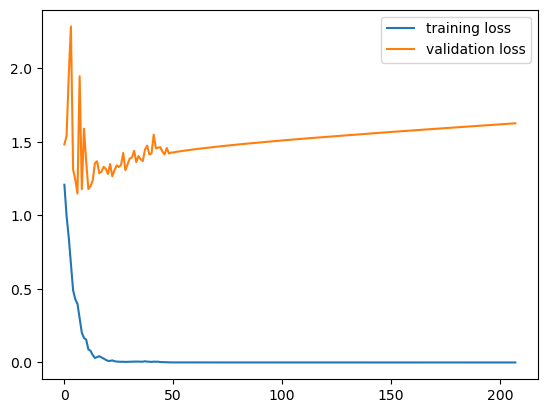

29
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
29
cd16
4608


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1373 loss_val: 1.1677 time: 9.4483s
 Epoch: 0010 loss_train: 0.4535 loss_val: 1.5761 time: 7.5116s
 Epoch: 0020 loss_train: 0.1684 loss_val: 2.2286 time: 9.2441s
 Epoch: 0030 loss_train: 0.0528 loss_val: 2.8563 time: 7.4418s
 Epoch: 0040 loss_train: 0.0191 loss_val: 2.5974 time: 8.1177s
 Epoch: 0050 loss_train: 0.0213 loss_val: 2.7742 time: 6.4850s
 Epoch: 0060 loss_train: 0.0017 loss_val: 2.6576 time: 6.8532s
 Epoch: 0070 loss_train: 0.0009 loss_val: 2.7024 time: 8.0871s
 Epoch: 0080 loss_train: 0.0008 loss_val: 2.7359 time: 9.0012s
 Epoch: 0090 loss_train: 0.0006 loss_val: 2.7609 time: 7.5304s
 Epoch: 0100 loss_train: 0.0007 loss_val: 2.7838 time: 7.1046s
 Epoch: 0110 loss_train: 0.0006 loss_val: 2.8063 time: 7.7950s
 Epoch: 0120 loss_train: 0.0005 loss_val: 2.8210 time: 9.3416s
 Epoch: 0130 loss_train: 0.0005 loss_val: 2.8451 time: 8.0639s
 Epoch: 0140 loss_train: 0.0005 loss_val: 2.8638 time: 7.3117s
 Epoch: 0150 loss_train: 0.0005 loss_val: 2.8841 time: 

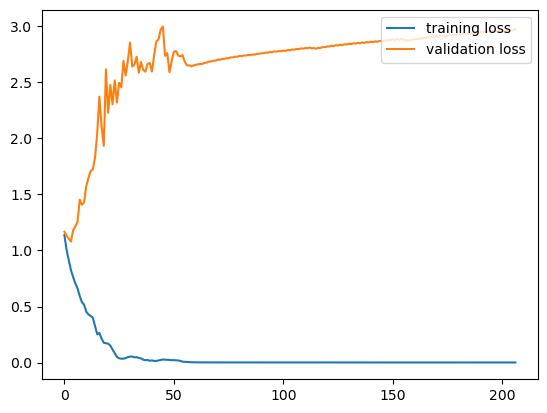

cd3
3822


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0132 loss_val: 1.0828 time: 7.7115s
 Epoch: 0010 loss_train: 0.1300 loss_val: 1.2549 time: 6.7763s
 Epoch: 0020 loss_train: 0.0201 loss_val: 1.3255 time: 7.8968s
 Epoch: 0030 loss_train: 0.0163 loss_val: 1.4849 time: 7.4326s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.4309 time: 6.4714s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.4442 time: 8.0166s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.4581 time: 6.8676s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4713 time: 8.1829s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4840 time: 8.3184s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4961 time: 8.4090s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5077 time: 8.1867s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5189 time: 7.6580s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5296 time: 6.6850s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5401 time: 8.5363s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5504 time: 7.4254s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5605 time: 

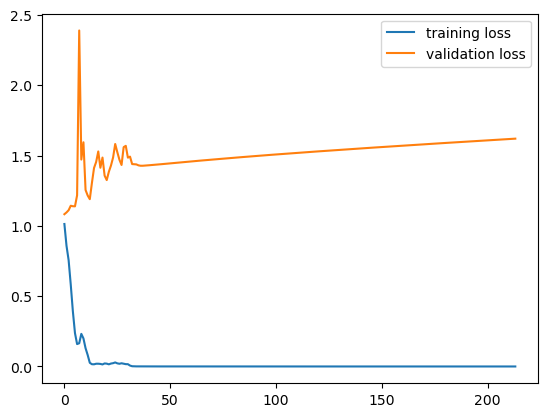

cd4
5637


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2010 loss_val: 1.3716 time: 11.8384s
 Epoch: 0010 loss_train: 0.4188 loss_val: 1.3814 time: 11.0687s
 Epoch: 0020 loss_train: 0.1319 loss_val: 2.0836 time: 12.4006s
 Epoch: 0030 loss_train: 0.0035 loss_val: 2.1268 time: 11.8950s
 Epoch: 0040 loss_train: 0.0008 loss_val: 2.1997 time: 11.5820s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.2521 time: 10.4149s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.2933 time: 12.0154s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.3287 time: 10.9469s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.3604 time: 11.0171s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.3894 time: 12.3183s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.4162 time: 11.1242s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.4418 time: 12.1839s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.4662 time: 12.0860s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.4898 time: 9.6424s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.5125 time: 11.9929s
 Epoch: 0150 loss_train: 0.0001 loss_val:

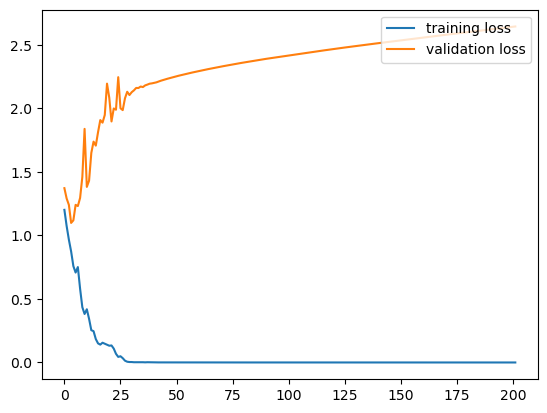

cd8
5659


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1992 loss_val: 1.6246 time: 11.7006s
 Epoch: 0010 loss_train: 0.0954 loss_val: 1.8827 time: 9.9927s
 Epoch: 0020 loss_train: 0.0069 loss_val: 1.8253 time: 9.7003s
 Epoch: 0030 loss_train: 0.0013 loss_val: 1.9124 time: 10.0005s
 Epoch: 0040 loss_train: 0.0007 loss_val: 1.9665 time: 10.9272s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.0112 time: 10.7124s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.0464 time: 11.5137s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.0768 time: 10.5723s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.1040 time: 7.3097s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.1290 time: 11.2302s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.1522 time: 11.5533s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.1743 time: 10.9707s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.1953 time: 10.5619s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.2154 time: 11.9353s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.2350 time: 10.5635s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2

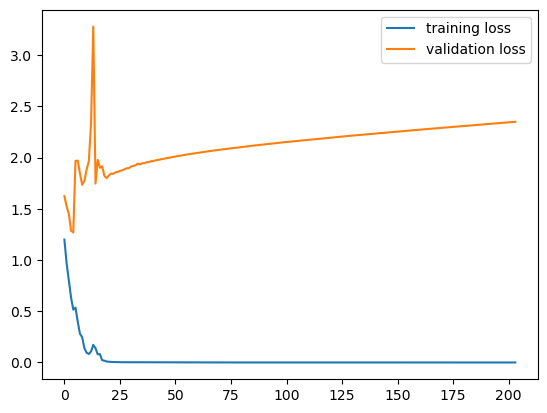

gh2ax
4938


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0332 loss_val: 1.6501 time: 9.8617s
 Epoch: 0010 loss_train: 0.0102 loss_val: 1.2858 time: 9.2345s
 Epoch: 0020 loss_train: 0.0008 loss_val: 1.2492 time: 11.4543s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.2889 time: 10.2005s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.3198 time: 9.7062s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.3457 time: 9.9293s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3685 time: 9.0830s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3890 time: 9.5889s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.4078 time: 10.3996s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4253 time: 9.4147s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4417 time: 11.0067s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4571 time: 10.0384s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4721 time: 9.1675s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4864 time: 8.9802s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.5001 time: 9.7296s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.5135 t

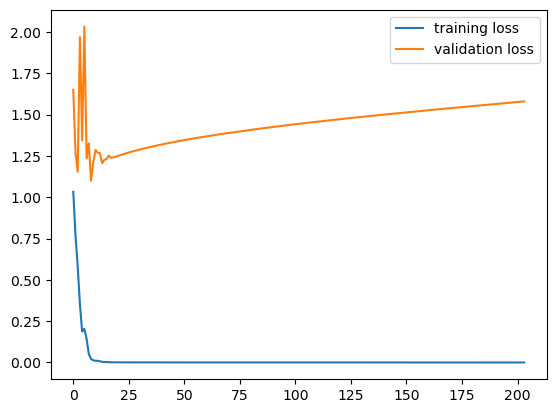

lamin
4939


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1964 loss_val: 1.4473 time: 8.0197s
 Epoch: 0010 loss_train: 0.1691 loss_val: 1.4546 time: 8.5808s
 Epoch: 0020 loss_train: 0.0176 loss_val: 1.4270 time: 9.1385s
 Epoch: 0030 loss_train: 0.0015 loss_val: 1.4192 time: 10.8565s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.4345 time: 7.9130s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.4590 time: 8.0952s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.4801 time: 9.6807s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4989 time: 10.3590s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.5162 time: 9.4079s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.5321 time: 8.6159s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5472 time: 9.2849s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5617 time: 9.0745s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5756 time: 10.3712s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5887 time: 8.6538s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6017 time: 8.8294s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6142 tim

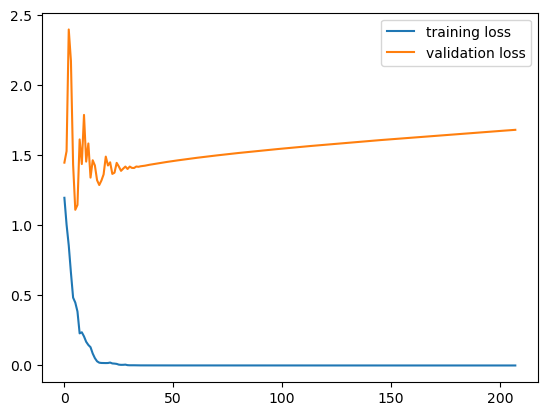

30
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
30
cd16
4555


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1350 loss_val: 1.1999 time: 8.1269s
 Epoch: 0010 loss_train: 0.4802 loss_val: 1.9113 time: 10.5060s
 Epoch: 0020 loss_train: 0.2072 loss_val: 2.0587 time: 10.8316s
 Epoch: 0030 loss_train: 0.0223 loss_val: 2.6166 time: 10.3344s
 Epoch: 0040 loss_train: 0.0436 loss_val: 3.0904 time: 10.3846s
 Epoch: 0050 loss_train: 0.0180 loss_val: 3.0083 time: 8.4565s
 Epoch: 0060 loss_train: 0.0075 loss_val: 2.7776 time: 9.8179s
 Epoch: 0070 loss_train: 0.0017 loss_val: 2.6737 time: 9.4631s
 Epoch: 0080 loss_train: 0.0010 loss_val: 2.6946 time: 11.2360s
 Epoch: 0090 loss_train: 0.0011 loss_val: 2.7171 time: 9.3769s
 Epoch: 0100 loss_train: 0.0009 loss_val: 2.7357 time: 8.6625s
 Epoch: 0110 loss_train: 0.0008 loss_val: 2.7524 time: 8.6411s
 Epoch: 0120 loss_train: 0.0009 loss_val: 2.7720 time: 9.8807s
 Epoch: 0130 loss_train: 0.0009 loss_val: 2.7876 time: 9.9338s
 Epoch: 0140 loss_train: 0.0009 loss_val: 2.8044 time: 8.9904s
 Epoch: 0150 loss_train: 0.0008 loss_val: 2.8200 t

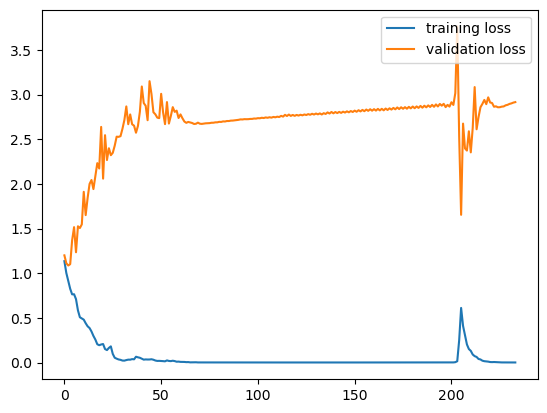

cd3
3760


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0369 loss_val: 1.0931 time: 7.6847s
 Epoch: 0010 loss_train: 0.0378 loss_val: 1.2849 time: 8.8356s
 Epoch: 0020 loss_train: 0.0375 loss_val: 2.0596 time: 8.1550s
 Epoch: 0030 loss_train: 0.0310 loss_val: 1.7870 time: 7.5150s
 Epoch: 0040 loss_train: 0.0627 loss_val: 1.9250 time: 7.0255s
 Epoch: 0050 loss_train: 0.0051 loss_val: 1.4925 time: 7.9048s
 Epoch: 0060 loss_train: 0.0004 loss_val: 1.4802 time: 7.9283s
 Epoch: 0070 loss_train: 0.0003 loss_val: 1.4949 time: 7.1668s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.5079 time: 7.1507s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.5199 time: 6.7395s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5307 time: 7.8861s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5409 time: 8.6625s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5506 time: 7.2017s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5596 time: 6.0382s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5683 time: 7.3621s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5769 time: 

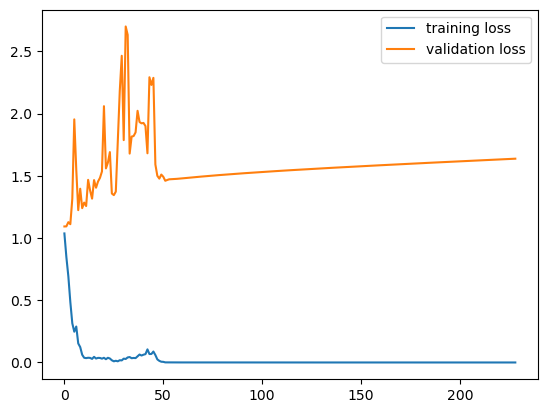

cd4
5580


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1937 loss_val: 1.4490 time: 10.5535s
 Epoch: 0010 loss_train: 0.3384 loss_val: 1.6450 time: 9.7215s
 Epoch: 0020 loss_train: 0.0836 loss_val: 1.9599 time: 10.5764s
 Epoch: 0030 loss_train: 0.0112 loss_val: 2.3138 time: 10.1081s
 Epoch: 0040 loss_train: 0.0065 loss_val: 2.4384 time: 9.2561s
 Epoch: 0050 loss_train: 0.0075 loss_val: 2.5032 time: 11.3127s
 Epoch: 0060 loss_train: 0.0005 loss_val: 2.4358 time: 9.4153s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.4797 time: 9.5048s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.5059 time: 10.1304s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.5288 time: 10.3666s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.5499 time: 11.0218s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.5696 time: 10.6430s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.5885 time: 9.8413s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.6066 time: 9.2885s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.6242 time: 10.3161s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.64

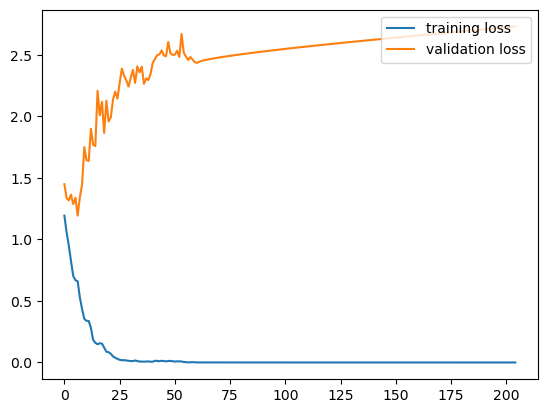

cd8
5604


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1859 loss_val: 1.7058 time: 8.9808s
 Epoch: 0010 loss_train: 0.1651 loss_val: 1.8362 time: 11.3125s
 Epoch: 0020 loss_train: 0.0063 loss_val: 1.9257 time: 12.8171s
 Epoch: 0030 loss_train: 0.0025 loss_val: 1.9971 time: 12.6437s
 Epoch: 0040 loss_train: 0.0020 loss_val: 2.0516 time: 10.9597s
 Epoch: 0050 loss_train: 0.0019 loss_val: 2.0949 time: 11.2519s
 Epoch: 0060 loss_train: 0.0016 loss_val: 2.1297 time: 11.1870s
 Epoch: 0070 loss_train: 0.0015 loss_val: 2.1647 time: 10.6437s
 Epoch: 0080 loss_train: 0.0016 loss_val: 2.1858 time: 10.4535s
 Epoch: 0090 loss_train: 0.1898 loss_val: 2.6598 time: 11.5816s
 Epoch: 0100 loss_train: 0.0038 loss_val: 2.2155 time: 11.8605s
 Epoch: 0110 loss_train: 0.0014 loss_val: 2.2801 time: 11.6456s
 Epoch: 0120 loss_train: 0.0015 loss_val: 2.3346 time: 9.0111s
 Epoch: 0130 loss_train: 0.0012 loss_val: 2.3618 time: 9.8032s
 Epoch: 0140 loss_train: 0.0011 loss_val: 2.3843 time: 12.6221s
 Epoch: 0150 loss_train: 0.0012 loss_val: 2

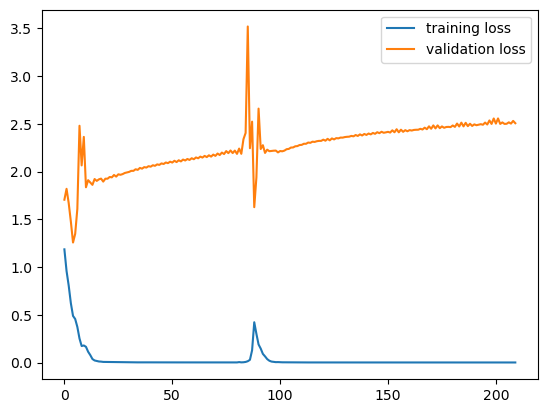

gh2ax
4837


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0270 loss_val: 1.7921 time: 10.0159s
 Epoch: 0010 loss_train: 0.0123 loss_val: 0.9707 time: 9.5832s
 Epoch: 0020 loss_train: 0.0009 loss_val: 0.9966 time: 10.2498s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.0342 time: 9.6077s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.0629 time: 9.8638s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.0868 time: 10.7401s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.1075 time: 10.4571s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.1257 time: 10.8489s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.1421 time: 10.5069s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.1572 time: 9.2066s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.1713 time: 9.5490s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.1845 time: 11.3238s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.1970 time: 8.1546s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.2089 time: 8.7352s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.2203 time: 9.8747s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.2314

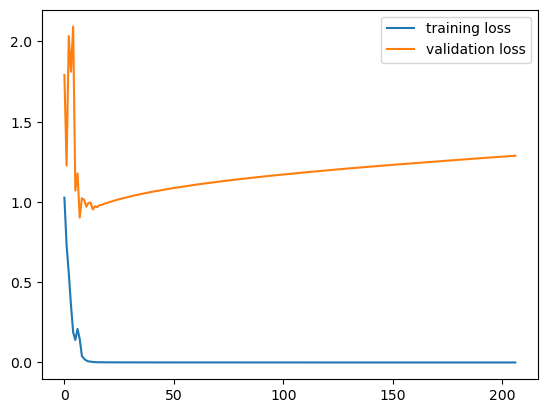

lamin
4838


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1361 loss_val: 1.6405 time: 6.7612s
 Epoch: 0010 loss_train: 0.0863 loss_val: 1.1096 time: 9.5156s
 Epoch: 0020 loss_train: 0.0194 loss_val: 1.4644 time: 10.3550s
 Epoch: 0030 loss_train: 0.0771 loss_val: 1.4289 time: 8.2644s
 Epoch: 0040 loss_train: 0.0119 loss_val: 1.4332 time: 7.7191s
 Epoch: 0050 loss_train: 0.0007 loss_val: 1.3534 time: 7.3047s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.3694 time: 8.4168s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3847 time: 9.1810s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.3975 time: 9.0646s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4092 time: 7.8882s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4199 time: 8.5995s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4299 time: 7.8879s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4393 time: 7.3108s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4485 time: 9.8694s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4574 time: 9.1769s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.4661 time:

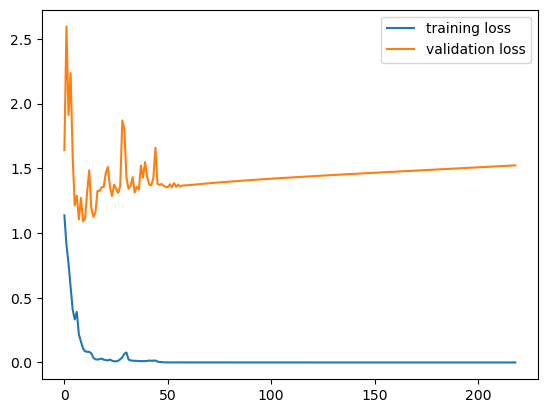

31
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
31
cd16
4490


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1642 loss_val: 1.1973 time: 8.2305s
 Epoch: 0010 loss_train: 0.4717 loss_val: 1.9331 time: 8.4743s
 Epoch: 0020 loss_train: 0.1340 loss_val: 2.2028 time: 9.1563s
 Epoch: 0030 loss_train: 0.0085 loss_val: 2.6150 time: 8.5277s
 Epoch: 0040 loss_train: 0.0215 loss_val: 3.1161 time: 8.0259s
 Epoch: 0050 loss_train: 0.0063 loss_val: 2.5861 time: 8.4330s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.5790 time: 9.1424s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.6040 time: 6.9255s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.6262 time: 8.6515s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.6468 time: 8.0787s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.6661 time: 8.6927s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.6842 time: 8.2697s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.7018 time: 9.6062s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.7188 time: 10.3014s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.7352 time: 7.5894s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.7513 time:

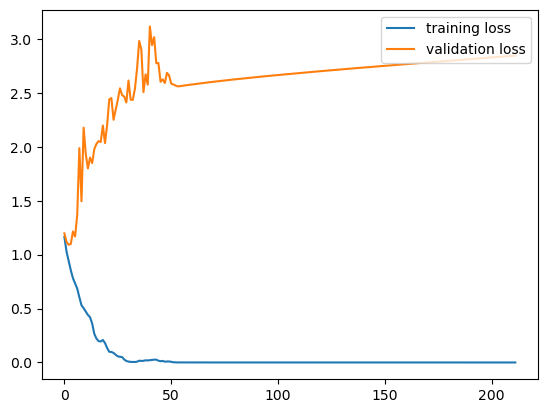

cd3
3802


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9926 loss_val: 1.0856 time: 7.6588s
 Epoch: 0010 loss_train: 0.0368 loss_val: 1.0409 time: 6.9383s
 Epoch: 0020 loss_train: 0.0173 loss_val: 1.3432 time: 6.4345s
 Epoch: 0030 loss_train: 0.0428 loss_val: 2.0689 time: 7.3583s
 Epoch: 0040 loss_train: 0.0363 loss_val: 1.4602 time: 6.9264s
 Epoch: 0050 loss_train: 0.0005 loss_val: 1.3056 time: 7.4487s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.3267 time: 6.9712s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3434 time: 7.9972s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.3573 time: 6.8440s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3697 time: 7.2296s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3811 time: 7.1634s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3917 time: 6.1659s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4019 time: 7.1529s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4116 time: 6.6016s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4207 time: 7.0016s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.4296 time: 

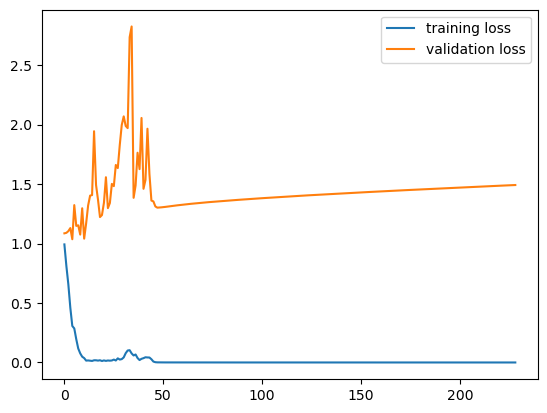

cd4
5518


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1963 loss_val: 1.4594 time: 9.8023s
 Epoch: 0010 loss_train: 0.3797 loss_val: 1.7307 time: 9.7825s
 Epoch: 0020 loss_train: 0.1292 loss_val: 1.8629 time: 7.5518s
 Epoch: 0030 loss_train: 0.0142 loss_val: 2.4454 time: 8.5731s
 Epoch: 0040 loss_train: 0.0095 loss_val: 2.6225 time: 8.9064s
 Epoch: 0050 loss_train: 0.0089 loss_val: 2.7438 time: 9.8589s
 Epoch: 0060 loss_train: 0.0121 loss_val: 2.7723 time: 9.0889s
 Epoch: 0070 loss_train: 0.1235 loss_val: 2.6731 time: 9.9281s
 Epoch: 0080 loss_train: 0.0003 loss_val: 2.5720 time: 10.0845s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.6011 time: 9.8041s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.6254 time: 10.2045s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.6458 time: 11.0235s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.6643 time: 10.8342s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.6816 time: 9.4890s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.6980 time: 11.9265s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.7138 t

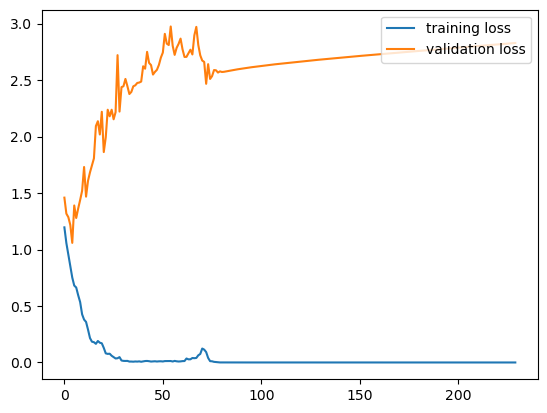

cd8
5545


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2151 loss_val: 1.5565 time: 9.1072s
 Epoch: 0010 loss_train: 0.1150 loss_val: 2.1796 time: 9.1555s
 Epoch: 0020 loss_train: 0.0014 loss_val: 1.9738 time: 9.1129s
 Epoch: 0030 loss_train: 0.0007 loss_val: 2.0432 time: 10.0021s
 Epoch: 0040 loss_train: 0.0005 loss_val: 2.0929 time: 11.4464s
 Epoch: 0050 loss_train: 0.0003 loss_val: 2.1338 time: 9.8906s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.1689 time: 11.4908s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.2000 time: 9.8235s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.2281 time: 10.4981s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.2542 time: 8.8290s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.2788 time: 9.8702s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.3024 time: 9.0292s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.3248 time: 9.9049s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.3463 time: 10.0375s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.3671 time: 8.2303s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.3876 t

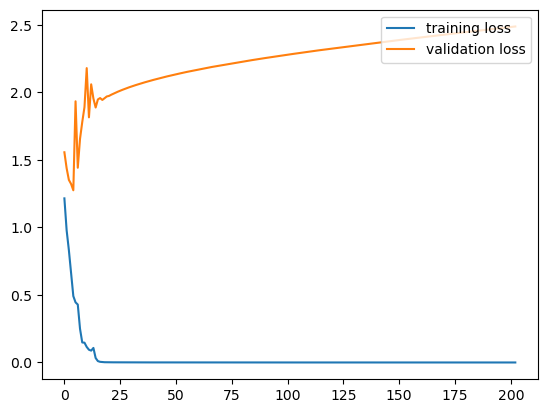

gh2ax
4931


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0029 loss_val: 2.0874 time: 7.7825s
 Epoch: 0010 loss_train: 0.0187 loss_val: 1.1040 time: 8.0533s
 Epoch: 0020 loss_train: 0.0008 loss_val: 1.1221 time: 8.8308s
 Epoch: 0030 loss_train: 0.0004 loss_val: 1.1612 time: 9.3564s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.1902 time: 8.6500s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.2142 time: 8.3628s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.2350 time: 9.2561s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.2538 time: 9.5597s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.2710 time: 9.3114s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.2869 time: 9.7896s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3018 time: 8.4620s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3160 time: 9.5372s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3295 time: 8.9027s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3426 time: 9.6291s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.3552 time: 10.6993s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.3674 time:

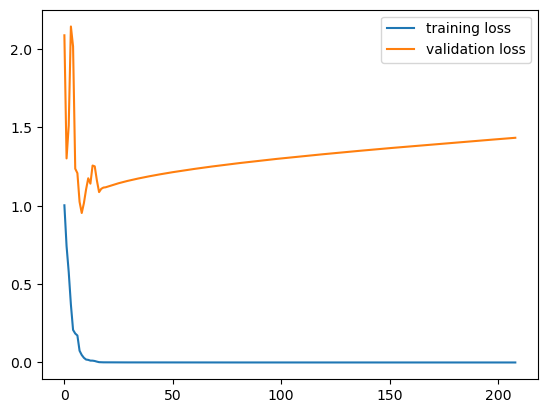

lamin
4932


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1915 loss_val: 1.7354 time: 8.2520s
 Epoch: 0010 loss_train: 0.0828 loss_val: 1.2789 time: 9.5256s
 Epoch: 0020 loss_train: 0.0273 loss_val: 1.5035 time: 8.5397s
 Epoch: 0030 loss_train: 0.0177 loss_val: 1.4626 time: 8.3495s
 Epoch: 0040 loss_train: 0.0014 loss_val: 1.4616 time: 7.4966s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.4613 time: 7.3028s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.4770 time: 6.3683s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4912 time: 8.6236s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.5045 time: 7.5430s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5169 time: 8.6339s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5290 time: 8.8015s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5404 time: 7.9518s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5517 time: 8.9135s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5625 time: 8.3969s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5731 time: 7.2285s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5836 time: 

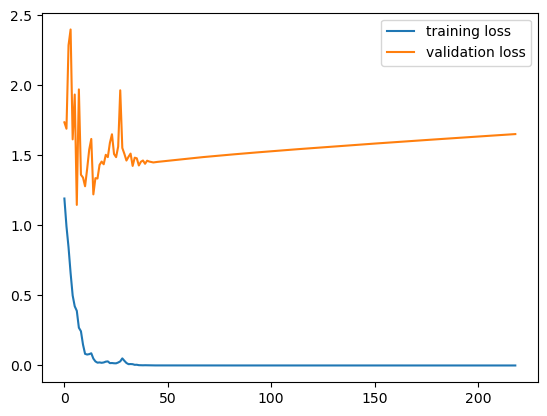

32
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
32
cd16
4629


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1409 loss_val: 1.1710 time: 8.2962s
 Epoch: 0010 loss_train: 0.4456 loss_val: 1.5775 time: 8.1511s
 Epoch: 0020 loss_train: 0.1290 loss_val: 2.3025 time: 7.0791s
 Epoch: 0030 loss_train: 0.0463 loss_val: 2.5537 time: 7.7710s
 Epoch: 0040 loss_train: 0.0294 loss_val: 2.7294 time: 7.6628s
 Epoch: 0050 loss_train: 0.0038 loss_val: 2.6110 time: 6.6727s
 Epoch: 0060 loss_train: 0.0016 loss_val: 2.6530 time: 7.2466s
 Epoch: 0070 loss_train: 0.0003 loss_val: 2.6750 time: 7.0675s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.7072 time: 4.9985s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.7338 time: 8.0342s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.7573 time: 8.9668s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.7789 time: 6.2332s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.7989 time: 8.7360s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.8181 time: 8.0134s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.8367 time: 8.5448s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.8547 time: 

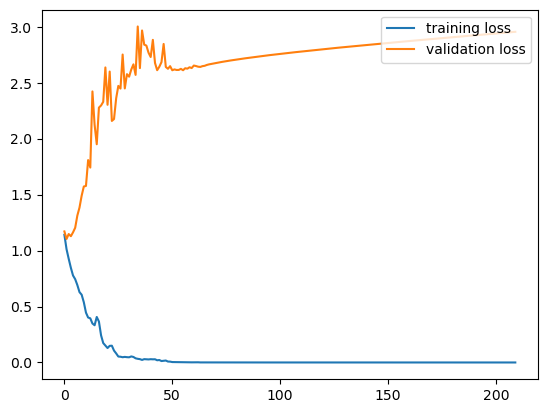

cd3
3806


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0217 loss_val: 1.1002 time: 7.1513s
 Epoch: 0010 loss_train: 0.0628 loss_val: 1.2614 time: 6.3688s
 Epoch: 0020 loss_train: 0.0257 loss_val: 1.6040 time: 5.9408s
 Epoch: 0030 loss_train: 0.0410 loss_val: 1.7590 time: 5.6547s
 Epoch: 0040 loss_train: 0.0385 loss_val: 1.6968 time: 7.2660s
 Epoch: 0050 loss_train: 0.0495 loss_val: 2.2144 time: 6.4991s
 Epoch: 0060 loss_train: 0.0004 loss_val: 1.6027 time: 6.6801s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.6030 time: 6.5780s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.6111 time: 7.4751s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.6197 time: 8.0038s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6283 time: 7.7092s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6367 time: 6.9242s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6450 time: 7.0897s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6531 time: 7.1802s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6609 time: 6.1569s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6688 time: 

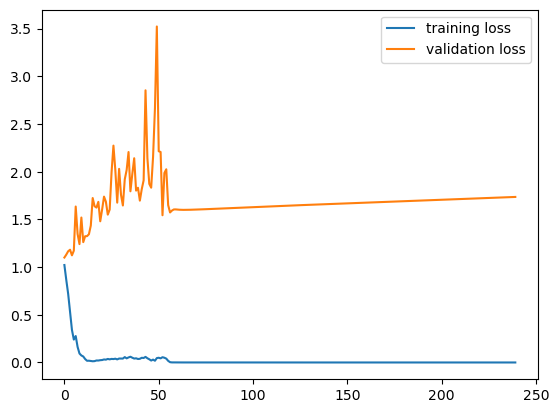

cd4
5663


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2137 loss_val: 1.4714 time: 9.3512s
 Epoch: 0010 loss_train: 0.4635 loss_val: 1.4769 time: 9.8472s
 Epoch: 0020 loss_train: 0.1144 loss_val: 1.9955 time: 9.0680s
 Epoch: 0030 loss_train: 0.0381 loss_val: 2.2593 time: 9.2917s
 Epoch: 0040 loss_train: 0.0012 loss_val: 2.3093 time: 9.8884s
 Epoch: 0050 loss_train: 0.0006 loss_val: 2.3513 time: 9.7632s
 Epoch: 0060 loss_train: 0.0005 loss_val: 2.3861 time: 9.3376s
 Epoch: 0070 loss_train: 0.0005 loss_val: 2.4257 time: 10.0756s
 Epoch: 0080 loss_train: 0.0004 loss_val: 2.4490 time: 9.4219s
 Epoch: 0090 loss_train: 0.0005 loss_val: 2.4878 time: 9.3065s
 Epoch: 0100 loss_train: 0.0004 loss_val: 2.5032 time: 9.9155s
 Epoch: 0110 loss_train: 0.0005 loss_val: 2.5498 time: 9.1162s
 Epoch: 0120 loss_train: 0.0003 loss_val: 2.5374 time: 10.8223s
 Epoch: 0130 loss_train: 0.0003 loss_val: 2.5638 time: 10.2320s
 Epoch: 0140 loss_train: 0.0004 loss_val: 2.6068 time: 11.0890s
 Epoch: 0150 loss_train: 0.0003 loss_val: 2.6106 ti

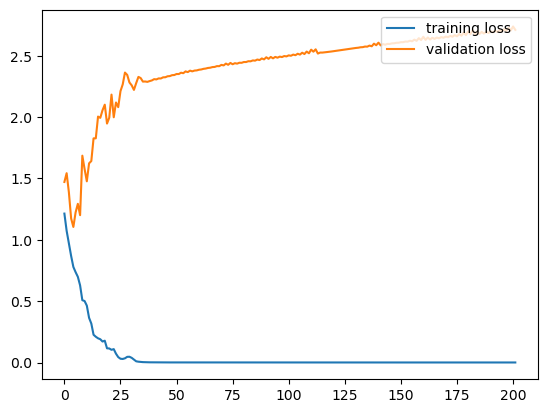

cd8
5687


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2152 loss_val: 1.6602 time: 8.6923s
 Epoch: 0010 loss_train: 0.2065 loss_val: 1.8968 time: 10.1325s
 Epoch: 0020 loss_train: 0.0236 loss_val: 2.3808 time: 8.4736s
 Epoch: 0030 loss_train: 0.0026 loss_val: 2.1009 time: 9.8716s
 Epoch: 0040 loss_train: 0.0005 loss_val: 2.1521 time: 9.4119s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.1962 time: 9.8848s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.2325 time: 9.2511s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.2641 time: 9.0984s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.2929 time: 10.7528s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.3194 time: 9.8161s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.3443 time: 9.1316s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.3680 time: 9.5735s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.3908 time: 9.1655s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.4125 time: 8.1221s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.4339 time: 9.6653s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.4548 time

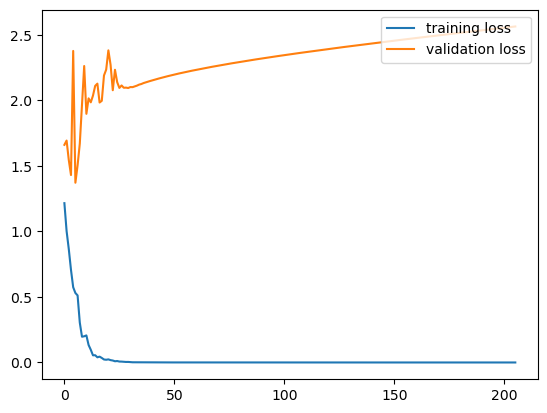

gh2ax
4889


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0641 loss_val: 1.7774 time: 8.5678s
 Epoch: 0010 loss_train: 0.0180 loss_val: 1.2869 time: 9.0271s
 Epoch: 0020 loss_train: 0.0009 loss_val: 1.1949 time: 8.2871s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.2330 time: 7.6210s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.2643 time: 8.6607s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.2906 time: 8.1135s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3135 time: 8.2381s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3340 time: 8.6869s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3528 time: 7.7141s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3700 time: 9.0582s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3862 time: 8.4862s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4015 time: 8.2058s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4161 time: 7.1378s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4301 time: 7.8296s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.4435 time: 8.2399s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4567 time: 

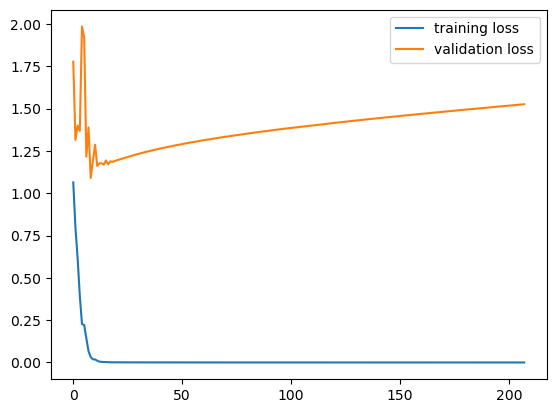

lamin
4890


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2012 loss_val: 1.3801 time: 7.7204s
 Epoch: 0010 loss_train: 0.1103 loss_val: 1.3176 time: 8.1932s
 Epoch: 0020 loss_train: 0.0103 loss_val: 1.3146 time: 8.3268s
 Epoch: 0030 loss_train: 0.0059 loss_val: 1.3995 time: 7.9710s
 Epoch: 0040 loss_train: 0.0092 loss_val: 1.5428 time: 7.5580s
 Epoch: 0050 loss_train: 0.1118 loss_val: 1.7290 time: 8.4878s
 Epoch: 0060 loss_train: 0.0006 loss_val: 1.4587 time: 7.8339s
 Epoch: 0070 loss_train: 0.0004 loss_val: 1.4837 time: 7.6055s
 Epoch: 0080 loss_train: 0.0003 loss_val: 1.5026 time: 8.5475s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.5187 time: 8.0038s
 Epoch: 0100 loss_train: 0.0002 loss_val: 1.5333 time: 7.7303s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5467 time: 7.4590s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5593 time: 7.1406s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5712 time: 7.0416s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5825 time: 8.5152s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5934 time: 

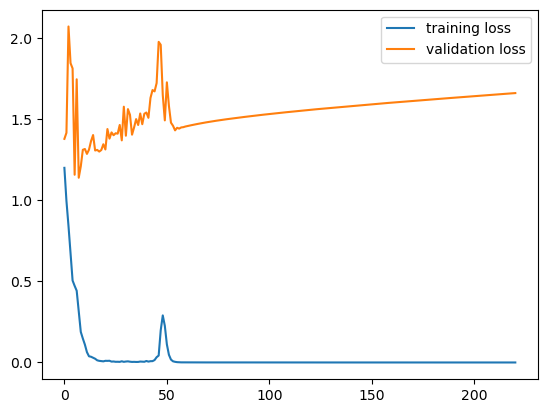

33
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
33
cd16
4560


/tmp/ipykernel_1555026/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555026/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1519 loss_val: 1.1936 time: 5.0414s
 Epoch: 0010 loss_train: 0.4705 loss_val: 2.3169 time: 6.6948s
 Epoch: 0020 loss_train: 0.2025 loss_val: 2.3934 time: 8.1233s
 Epoch: 0030 loss_train: 0.0453 loss_val: 2.2579 time: 6.5677s
 Epoch: 0040 loss_train: 0.0206 loss_val: 2.4293 time: 6.4745s
 Epoch: 0050 loss_train: 0.0040 loss_val: 2.4115 time: 6.7339s
 Epoch: 0060 loss_train: 0.0014 loss_val: 2.4485 time: 6.4077s


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
for sample_s in range(prevSampled,nSamples):
    print(sample_s)
    imgsC_all_samples_s=None
    imgsP_all_samples_s=None
    imgNames_all_samples_s=None
    proteinNames_samples_s=None
    pID_all_samples_s=None
    conditions_all_samples_s=None
    
    imgsC_all_val_samples_s={}
    imgsP_all_val_samples_s={}
    imgNames_all_val_samples_s={}
    proteinTrainInput_val_samples_s={}
    pID_all_val_samples_s={}
    conditions_all_val_samples_s={}
    for condition_i in conditions:
        print(condition_i)
        segDir_i=os.path.join(segDir,condition_i)
        imgDir_i=os.path.join(imgDir,condition_i)
        for stain in os.listdir(segDir_i):
            print(stain)
            segDir_i_stain=os.path.join(segDir_i,stain)
            imgDir_i_stain=os.path.join(imgDir_i,stain)

            segPID2name={}
            for pID_dir in os.listdir(segDir_i_stain):
                pID=pID_dir.split('_')
                segPID2name[pID[0]]=pID_dir
            imgPID2name={}
            for pID_dir in os.listdir(imgDir_i_stain):
                pID=pID_dir.split('_')
                imgPID2name[pID[0]]=pID_dir
            for pID in segPID2name.keys():
                if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                    continue
                if pID in holdOutSamples_samples[sample_s%6]:
                    print('hold out: '+pID)
                    continue
                print(pID)
                if pID not in imgPID2name:
                    print('img not found '+pID)
                    continue
                imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
                segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])

                with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                    imgNames=pickle.load(output)
                with open(os.path.join(imgDir_i_stain_p,savename+'_img'), 'rb') as output:
                    img=pickle.load(output)

                imgP=np.zeros((img.shape[0],1,img.shape[2],img.shape[3]))
                proteinNames_curr=np.array([])
                stain_list=stain.split('_')
                nImgPerStain=int(img.shape[0]/(len(stain_list)-1))
                np.random.seed(sample_s+6)
                allIdx_all=np.arange(img.shape[0])
                np.random.shuffle(allIdx_all)
                for s in range(1,len(stain_list)):
                    s_start=(s-1)*nImgPerStain
                    if s==len(stain_list)-1:
                        s_end=img.shape[0]
                    else:
                        s_end=s*nImgPerStain
                    imgP[s_start:s_end]=img[allIdx_all[s_start:s_end],s].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                    proteinNames_curr=np.concatenate((proteinNames_curr,np.repeat(stain_list[s],s_end-s_start)))

                    #store other channels for validation
                    for sother in range(1,len(stain_list)):
                        if sother==s:
                            continue
                        if stain_list[sother] not in imgsP_all_val_samples_s.keys():
                            proteinTrainInput_val_samples_s[stain_list[sother]]=np.repeat(stain_list[s],s_end-s_start)
                            pID_all_val_samples_s[stain_list[sother]]=np.repeat(pID,s_end-s_start)
                            imgsC_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                            imgNames_all_val_samples_s[stain_list[sother]]=imgNames[allIdx_all[s_start:s_end]]
                            imgsP_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                            conditions_all_val_samples_s[stain_list[sother]]=np.repeat(condition_i,s_end-s_start)
                        else:
                            proteinTrainInput_val_samples_s[stain_list[sother]]=np.concatenate((proteinTrainInput_val_samples_s[stain_list[sother]],np.repeat(stain_list[s],s_end-s_start)))
                            pID_all_val_samples_s[stain_list[sother]]=np.concatenate((pID_all_val_samples_s[stain_list[sother]],np.repeat(pID,s_end-s_start)))
                            imgsC_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsC_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                            imgNames_all_val_samples_s[stain_list[sother]]=np.concatenate((imgNames_all_val_samples_s[stain_list[sother]],imgNames[allIdx_all[s_start:s_end]]))
                            imgsP_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsP_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                            conditions_all_val_samples_s[stain_list[sother]]=np.concatenate((conditions_all_val_samples_s[stain_list[sother]],np.repeat(condition_i,s_end-s_start)))
                if pID_all_samples_s is None:
                    pID_all_samples_s=np.repeat(pID,img.shape[0])
                    imgsC_all_samples_s=img[allIdx_all,[0]]
                    imgNames_all_samples_s=imgNames[allIdx_all]
                    proteinNames_samples_s=proteinNames_curr
                    imgsP_all_samples_s=imgP
                    conditions_all_samples_s=np.repeat(condition_i,img.shape[0])
                else:
                    pID_all_samples_s=np.concatenate((pID_all_samples_s,np.repeat(pID,img.shape[0])))
                    imgsC_all_samples_s=np.concatenate((imgsC_all_samples_s,img[allIdx_all,[0]]),axis=0)
                    imgNames_all_samples_s=np.concatenate((imgNames_all_samples_s,imgNames[allIdx_all]))
                    proteinNames_samples_s=np.concatenate((proteinNames_samples_s,proteinNames_curr))
                    imgsP_all_samples_s=np.concatenate((imgsP_all_samples_s,imgP),axis=0)
                    conditions_all_samples_s=np.concatenate((conditions_all_samples_s,np.repeat(condition_i,img.shape[0])))
    imgsC_all_samples_s=imgsC_all_samples_s.reshape(imgsC_all_samples_s.shape[0],1,imgsC_all_samples_s.shape[1],imgsC_all_samples_s.shape[2])
    
    
    print(sample_s)
    nProt=np.unique(proteinNames_samples_s).size
    pnames,revIdx,pCounts=np.unique(proteinNames_samples_s,return_inverse=True,return_counts=True)
    plabels=torch.tensor(np.arange(pnames.size)[revIdx]).long()
    
    for p_curr in np.unique(proteinNames_samples_s):
        print(p_curr)
        print(np.sum(proteinNames_samples_s==p_curr))

        logsavepath_train_curr=os.path.join(logsavepath_train,p_curr)
        modelsavepath_train_curr=os.path.join(modelsavepath_train,p_curr)
        plotsavepath_train_curr=os.path.join(plotsavepath_train,p_curr)
        if not os.path.exists(logsavepath_train_curr):
            os.mkdir(logsavepath_train_curr)
        if not os.path.exists(modelsavepath_train_curr):
            os.mkdir(modelsavepath_train_curr)
        if not os.path.exists(plotsavepath_train_curr):
            os.mkdir(plotsavepath_train_curr)
        logsavepath_train_curr=os.path.join(logsavepath_train,p_curr,str(sample_s+6))
        modelsavepath_train_curr=os.path.join(modelsavepath_train,p_curr,str(sample_s+6))
        plotsavepath_train_curr=os.path.join(plotsavepath_train,p_curr,str(sample_s+6))
        if not os.path.exists(logsavepath_train_curr):
            os.mkdir(logsavepath_train_curr)
        if not os.path.exists(modelsavepath_train_curr):
            os.mkdir(modelsavepath_train_curr)
        if not os.path.exists(plotsavepath_train_curr):
            os.mkdir(plotsavepath_train_curr)

        imgsP_all_curr=imgsP_all_samples_s[proteinNames_samples_s==p_curr]
        imgsC_all_curr=imgsC_all_samples_s[proteinNames_samples_s==p_curr]
        conditions_all_curr=conditions_all_samples_s[proteinNames_samples_s==p_curr]
        cnames,revIdx_c,cCounts=np.unique(conditions_all_curr,return_inverse=True,return_counts=True)
        clfWeight=1/cCounts
        clfWeight=clfWeight/np.sum(clfWeight)
        loss_clf=torch.nn.CrossEntropyLoss(weight=torch.tensor(clfWeight).cuda().float())
        cnames_val,revIdx_c_val,cCounts_val=np.unique(conditions_all_val_samples_s[p_curr],return_inverse=True,return_counts=True)

        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        if modelname_train=='resnet18':
            model=torchvision.models.resnet18(num_classes=cnames.size)
            model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) #change to one input channel
        elif modelname_train=='alexnet':
            model=torchvision.models.alexnet(num_classes=cnames.size)
            model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        elif modelname_train=='cnn_base':
            model=model_clf.cnn_clf.CNN_VAE_clf(4, 2, 1, 1, 64,128,256,256,96, 96*4*4,64,cnames.size)
        model.cuda()
        optimizer_clf = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        #p2p - train samples
        starget_index=pnames.tolist().index(p_curr)
        plabels=torch.tensor(np.repeat(starget_index,imgsC_all_curr.shape[0])).long()
        valIdx=np.arange(imgsC_all_curr.shape[0])
        p2p_res_train=np.zeros_like(imgsP_all_curr)
        with torch.no_grad():
            nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
            for i in range(nvalBatches):
                valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
                valtarget_p=torch.tensor(imgsP_all_curr[valIdx_i]).cuda().float()
                valInput_ID=plabels[valIdx_i].cuda()
                valIdx_i=torch.tensor(valIdx_i)

                reconShared_protein_l,recon_protein_l= modelcnn_protein(valtarget_p,valInput_ID)

                recon_protein=modelcnn_protein_dec(torch.cat((reconShared_protein_l,recon_protein_l),dim=1),pIDemb_dec(valInput_ID))
                p2p_res_train[valIdx_i]=recon_protein.cpu().numpy()

        #p2p - validation samples
        imgP_p2p_target=imgsP_all_val_samples_s[p_curr]
        starget_index=pnames.tolist().index(p_curr)
        plabels=torch.tensor(np.repeat(starget_index,imgP_p2p_target.shape[0])).long()
        valIdx=np.arange(imgP_p2p_target.shape[0])

        p2p_res=np.zeros_like(imgP_p2p_target)
        with torch.no_grad():
            nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
            for i in range(nvalBatches):
                valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
                valtarget_p=torch.tensor(imgP_p2p_target[valIdx_i]).cuda().float()
                valInput_ID=plabels[valIdx_i].cuda()
                valIdx_i=torch.tensor(valIdx_i)

                reconShared_protein_l,recon_protein_l= modelcnn_protein(valtarget_p,valInput_ID)

                recon_protein=modelcnn_protein_dec(torch.cat((reconShared_protein_l,recon_protein_l),dim=1),pIDemb_dec(valInput_ID))
                p2p_res[valIdx_i]=recon_protein.cpu().numpy()

        #train classifier
        train_loss=[np.inf]*epochs
        val_loss=[np.inf]*epochs

        t_ep=time.time()

        epCounts=0
        for ep in range(epochs):
            train_loss[ep],val_loss[ep]=train(ep,model,optimizer_clf,p2p_res_train,p2p_res,torch.tensor(revIdx_c),torch.tensor(revIdx_c_val))

            if ep>50 and val_loss[ep]>=val_loss[ep-50]:
                epCounts+=1

            if epCounts>150:
                break


            if ep%saveFreq == (saveFreq-1):
                torch.save(model.cpu().state_dict(), os.path.join(modelsavepath_train_curr,'ep'+str(ep)+'.pt'))


            model.cuda()
            torch.cuda.empty_cache()
        print(' total time: {:.4f}s'.format(time.time() - t_ep))


        with open(os.path.join(logsavepath_train_curr,'train_loss'), 'wb') as output:
            pickle.dump(train_loss, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(logsavepath_train_curr,'val_loss'), 'wb') as output:
            pickle.dump(val_loss, output, pickle.HIGHEST_PROTOCOL)


        plt.plot(np.arange(epochs),train_loss)
        plt.plot(np.arange(epochs),val_loss)
        plt.legend(['training loss','validation loss'],loc='upper right')
        plt.savefig(os.path.join(plotsavepath_train_curr,'loss_seed3.jpg'))
        plt.show()


### validation samples

In [13]:
for p_curr in np.unique(proteinNames_samples_s):
    print(p_curr)
    nconditions=np.unique(conditions_all_samples_s[proteinNames_samples_s==p_curr]).size
    res_val=np.zeros((nSamples,nconditions,nconditions))
    correctCount_val=[None]*nSamples
    
    for sample_s in range(nSamples):
        imgsC_all_samples_s=None
        imgsP_all_samples_s=None
        imgNames_all_samples_s=None
        proteinNames_samples_s=None
        pID_all_samples_s=None
        conditions_all_samples_s=None

        imgsC_all_val_samples_s={}
        imgsP_all_val_samples_s={}
        imgNames_all_val_samples_s={}
        proteinTrainInput_val_samples_s={}
        pID_all_val_samples_s={}
        conditions_all_val_samples_s={}
        for condition_i in conditions:
            print(condition_i)
            segDir_i=os.path.join(segDir,condition_i)
            imgDir_i=os.path.join(imgDir,condition_i)
            for stain in os.listdir(segDir_i):
                print(stain)
                segDir_i_stain=os.path.join(segDir_i,stain)
                imgDir_i_stain=os.path.join(imgDir_i,stain)

                segPID2name={}
                for pID_dir in os.listdir(segDir_i_stain):
                    pID=pID_dir.split('_')
                    segPID2name[pID[0]]=pID_dir
                imgPID2name={}
                for pID_dir in os.listdir(imgDir_i_stain):
                    pID=pID_dir.split('_')
                    imgPID2name[pID[0]]=pID_dir
                for pID in segPID2name.keys():
                    if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                        continue
                    if pID in holdOutSamples_samples[sample_s%6]:
                        print('hold out: '+pID)
                        continue
                    print(pID)
                    if pID not in imgPID2name:
                        print('img not found '+pID)
                        continue
                    imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
                    segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])

                    with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                        imgNames=pickle.load(output)
                    with open(os.path.join(imgDir_i_stain_p,savename+'_img'), 'rb') as output:
                        img=pickle.load(output)

                    imgP=np.zeros((img.shape[0],1,img.shape[2],img.shape[3]))
                    proteinNames_curr=np.array([])
                    stain_list=stain.split('_')
                    nImgPerStain=int(img.shape[0]/(len(stain_list)-1))
                    np.random.seed(sample_s+6)
                    allIdx_all=np.arange(img.shape[0])
                    np.random.shuffle(allIdx_all)
                    for s in range(1,len(stain_list)):
                        s_start=(s-1)*nImgPerStain
                        if s==len(stain_list)-1:
                            s_end=img.shape[0]
                        else:
                            s_end=s*nImgPerStain
                        imgP[s_start:s_end]=img[allIdx_all[s_start:s_end],s].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                        proteinNames_curr=np.concatenate((proteinNames_curr,np.repeat(stain_list[s],s_end-s_start)))

                        #store other channels for validation
                        for sother in range(1,len(stain_list)):
                            if sother==s:
                                continue
                            if stain_list[sother] not in imgsP_all_val_samples_s.keys():
                                proteinTrainInput_val_samples_s[stain_list[sother]]=np.repeat(stain_list[s],s_end-s_start)
                                pID_all_val_samples_s[stain_list[sother]]=np.repeat(pID,s_end-s_start)
                                imgsC_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                                imgNames_all_val_samples_s[stain_list[sother]]=imgNames[allIdx_all[s_start:s_end]]
                                imgsP_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                                conditions_all_val_samples_s[stain_list[sother]]=np.repeat(condition_i,s_end-s_start)
                            else:
                                proteinTrainInput_val_samples_s[stain_list[sother]]=np.concatenate((proteinTrainInput_val_samples_s[stain_list[sother]],np.repeat(stain_list[s],s_end-s_start)))
                                pID_all_val_samples_s[stain_list[sother]]=np.concatenate((pID_all_val_samples_s[stain_list[sother]],np.repeat(pID,s_end-s_start)))
                                imgsC_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsC_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                                imgNames_all_val_samples_s[stain_list[sother]]=np.concatenate((imgNames_all_val_samples_s[stain_list[sother]],imgNames[allIdx_all[s_start:s_end]]))
                                imgsP_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsP_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                                conditions_all_val_samples_s[stain_list[sother]]=np.concatenate((conditions_all_val_samples_s[stain_list[sother]],np.repeat(condition_i,s_end-s_start)))
                    if pID_all_samples_s is None:
                        pID_all_samples_s=np.repeat(pID,img.shape[0])
                        imgsC_all_samples_s=img[allIdx_all,[0]]
                        imgNames_all_samples_s=imgNames[allIdx_all]
                        proteinNames_samples_s=proteinNames_curr
                        imgsP_all_samples_s=imgP
                        conditions_all_samples_s=np.repeat(condition_i,img.shape[0])
                    else:
                        pID_all_samples_s=np.concatenate((pID_all_samples_s,np.repeat(pID,img.shape[0])))
                        imgsC_all_samples_s=np.concatenate((imgsC_all_samples_s,img[allIdx_all,[0]]),axis=0)
                        imgNames_all_samples_s=np.concatenate((imgNames_all_samples_s,imgNames[allIdx_all]))
                        proteinNames_samples_s=np.concatenate((proteinNames_samples_s,proteinNames_curr))
                        imgsP_all_samples_s=np.concatenate((imgsP_all_samples_s,imgP),axis=0)
                        conditions_all_samples_s=np.concatenate((conditions_all_samples_s,np.repeat(condition_i,img.shape[0])))
        imgsC_all_samples_s=imgsC_all_samples_s.reshape(imgsC_all_samples_s.shape[0],1,imgsC_all_samples_s.shape[1],imgsC_all_samples_s.shape[2])


        print(sample_s)
        nProt=np.unique(proteinNames_samples_s).size
        pnames,revIdx,pCounts=np.unique(proteinNames_samples_s,return_inverse=True,return_counts=True)
        plabels=torch.tensor(np.arange(pnames.size)[revIdx]).long()

        plotsavepath_train_p=os.path.join(plotsavepath_train,p_curr)
        
        logsavepath_train_curr=os.path.join(logsavepath_train,p_curr,str(sample_s+6))
        modelsavepath_train_curr=os.path.join(modelsavepath_train,p_curr,str(sample_s+6))
        plotsavepath_train_curr=os.path.join(plotsavepath_train,p_curr,str(sample_s+6))

        imgsP_all_curr=imgsP_all_samples_s[proteinNames_samples_s==p_curr]
        conditions_all_curr=conditions_all_samples_s[proteinNames_samples_s==p_curr]
        cnames,revIdx_c,cCounts=np.unique(conditions_all_curr,return_inverse=True,return_counts=True)
        clfWeight=1/cCounts
        clfWeight=clfWeight/np.sum(clfWeight)
        loss_clf=torch.nn.CrossEntropyLoss(weight=torch.tensor(clfWeight).cuda().float())
        cnames_val,revIdx_c_val,cCounts_val=np.unique(conditions_all_val_samples_s[p_curr],return_inverse=True,return_counts=True)


        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        if modelname_train=='resnet18':
            model=torchvision.models.resnet18(num_classes=cnames.size)
            model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) #change to one input channel
        elif modelname_train=='alexnet':
            model=torchvision.models.alexnet(num_classes=cnames.size)
            model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        elif modelname_train=='cnn_base':
            model=model_clf.cnn_clf.CNN_VAE_clf(4, 2, 1, 1, 64,128,256,256,96, 96*4*4,64,cnames.size)

        model.cuda()

        with open(os.path.join(logsavepath_train_curr,'val_loss'), 'rb') as output:
            val_loss=pickle.load(output)
        minlossepoch=np.argmin(val_loss)
        minlossepoch_saved=int(np.round(minlossepoch/saveFreq)*saveFreq)-1
        if minlossepoch_saved==-1:
            minlossepoch_saved=saveFreq-1
        if val_loss[minlossepoch_saved-saveFreq]<val_loss[minlossepoch_saved]:
            if val_loss[minlossepoch_saved+saveFreq]<val_loss[minlossepoch_saved-saveFreq]:
                minlossepoch_saved=minlossepoch_saved+saveFreq
            else:
                minlossepoch_saved=minlossepoch_saved-saveFreq
        if minlossepoch_saved==-1:
            minlossepoch_saved=saveFreq-1
        model.load_state_dict(torch.load(os.path.join(modelsavepath_train_curr,'ep'+str(minlossepoch_saved)+'.pt')))

#         origImgPath=os.path.join('/data/xinyi/c2p/plots/',modelname_train,'conditionClf_origImg_sampling',p_curr,str(sample_s))
#         with open(os.path.join(origImgPath,'pred_val_moreSamples'), 'rb') as output:
#             pred_origImg_val=pickle.load(output)
            
        #p2p - validation samples
        imgP_p2p_target=imgsP_all_val_samples_s[p_curr]
        starget_index=pnames.tolist().index(p_curr)
        plabels=torch.tensor(np.repeat(starget_index,imgP_p2p_target.shape[0])).long()
        valIdx=np.arange(imgP_p2p_target.shape[0])

        p2p_res=np.zeros_like(imgP_p2p_target)
        with torch.no_grad():
            nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
            for i in range(nvalBatches):
                valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
                valtarget_p=torch.tensor(imgP_p2p_target[valIdx_i]).cuda().float()
                valInput_ID=plabels[valIdx_i].cuda()
                valIdx_i=torch.tensor(valIdx_i)

                reconShared_protein_l,recon_protein_l= modelcnn_protein(valtarget_p,valInput_ID)

                recon_protein=modelcnn_protein_dec(torch.cat((reconShared_protein_l,recon_protein_l),dim=1),pIDemb_dec(valInput_ID))
                p2p_res[valIdx_i]=recon_protein.cpu().numpy()


        #validation samples - p2p results
        with torch.no_grad():
            model.eval()
            loss_val_all=0
            valIdx=np.arange(revIdx_c_val.size)
            nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
            pred_curr_p2p=np.array([])
            for i in range(nvalBatches):
                valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
                val_labels=torch.tensor(revIdx_c_val[valIdx_i]).cuda().long()
                valInput=torch.tensor(p2p_res[valIdx_i]).cuda().float()


                pred = model(valInput)

                loss=loss_clf(pred, val_labels)
                loss_val_all+=loss.item()
                pred_curr_p2p=np.concatenate((pred_curr_p2p,np.argmax(pred.detach().cpu().numpy(),axis=1)))

            loss_val_all=loss_val_all/nvalBatches

        print('loss_val: {:.4f}'.format(loss_val_all))
        correctCount=np.sum(pred_curr_p2p==revIdx_c_val)/pred_curr_p2p.size
        print('acc: {:.4f}'.format(correctCount))

        pred_curr_p2p=pred_curr_p2p.astype(int)
    #     pred_curr_target=pred_curr_target.astype(int)
        res_val[sample_s]=plotCTcomp(cnames[revIdx_c_val],cnames[pred_curr_p2p],plotsavepath_train_curr,'confusion_val_p2p',False,addname='',ctorder=None,vmin=0,vmax=1)
#         res_val_orig[sample_s]=plotCTcomp(cnames[pred_origImg_val],cnames[pred_curr_p2p],plotsavepath_train_curr,'confusion_val_p2pVSorigImg',False,addname='',ctorder=None,vmin=0,vmax=1)
        

        with open(os.path.join(plotsavepath_train_curr,'pred_val'), 'wb') as output:
            pickle.dump(pred_curr_p2p, output, pickle.HIGHEST_PROTOCOL)

        correctCount_val[sample_s]=correctCount
#         correctCount_val_orig[sample_s]=np.sum(pred_curr_p2p==pred_origImg_val)/pred_curr_p2p.size
        
#         origCorrect=pred_origImg_val==revIdx_c_val
#         correctCount_val_orig_correctOnly[sample_s]=np.sum(pred_curr_p2p[origCorrect]==pred_origImg_val[origCorrect])/np.sum(origCorrect)
#         res_val_orig_correctOnly[sample_s]=plotCTcomp(cnames[pred_origImg_val[origCorrect]],cnames[pred_curr_p2p[origCorrect]],plotsavepath_train_curr,'confusion_val_p2pVSorigImg_correctOnly',False,addname='',ctorder=None,vmin=0,vmax=1)


    print('avg val acc: {:.4f}'.format(np.mean(correctCount_val)))
    with open(os.path.join(plotsavepath_train_p,'acc_val_moreSamples'), 'wb') as output:
        pickle.dump(correctCount_val, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(plotsavepath_train_p,'confusion_val_moreSamples'), 'wb') as output:
        pickle.dump(res_val, output, pickle.HIGHEST_PROTOCOL)

#     with open(os.path.join(plotsavepath_train_p,'acc_val_orig'), 'wb') as output:
#         pickle.dump(correctCount_val_orig, output, pickle.HIGHEST_PROTOCOL)
#     with open(os.path.join(plotsavepath_train_p,'acc_val_orig_correctOnly'), 'wb') as output:
#         pickle.dump(correctCount_val_orig_correctOnly, output, pickle.HIGHEST_PROTOCOL)
#     with open(os.path.join(plotsavepath_train_p,'confusion_val_orig'), 'wb') as output:
#         pickle.dump(res_val_orig, output, pickle.HIGHEST_PROTOCOL)
#     with open(os.path.join(plotsavepath_train_p,'confusion_val_orig_correctOnly'), 'wb') as output:
#         pickle.dump(res_val_orig_correctOnly, output, pickle.HIGHEST_PROTOCOL)




cd16
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
0
loss_val: 2.4581
acc: 0.4370
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd

hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
13
loss_val: 2.6040
acc: 0.4427
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
im

P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
26
loss_val: 2.6312
acc: 0.4079
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
27
loss_val: 2.4788
ac

hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
3
loss_val: 1.4183
acc: 0.6263
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
4
loss_val: 1.4381
acc: 0.6366
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_

P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
16
loss_val: 1.7083
acc: 0.6186
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
17
loss_val: 1.5495
acc: 0.6226
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
da

P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
30
loss_val: 1.5101
acc: 0.6293
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
31
loss_val: 1.3041
acc: 0.6719
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4


glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
7
loss_val: 2.4500
acc: 0.4750
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
8
loss_val: 2.4326
acc: 0.4501
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P5

P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
20
loss_val: 2.3832
acc: 0.4468
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
21
loss_val: 2.2887
acc: 0.4938
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2a

HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
34
loss_val: 2.5184
acc: 0.4773
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P3

P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
11
loss_val: 2.0669
acc: 0.4763
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P5

P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
24
loss_val: 2.3120
acc: 0.4624
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
25
loss_val: 2.0529
acc: 0.4752
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_

P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
1
loss_val: 1.1897
acc: 0.7077
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
2
loss_val: 1.2622
acc: 0.6856
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P1

dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
15
loss_val: 1.2700
acc: 0.6912
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
16
loss_val: 1.3272
acc: 0.6928
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P2

hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
29
loss_val: 1.3433
acc: 0.6858
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59


HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
6
loss_val: 1.3120
acc: 0.6837
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img

P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
19
loss_val: 2.4338
acc: 0.5937
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
20
loss_val: 1.4884
acc: 0

P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
32
loss_val: 1.4941
acc: 0.6114
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
33
loss_val: 1.5007
acc: 0.6424
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out